In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
%matplotlib inline
import seaborn as sns

In [2]:
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42

LABELS = ["Normal", "Fraud"]

In [3]:
train = pd.read_csv('provider_healthcare/Train-1542865627584.csv')
test = pd.read_csv('provider_healthcare/Test-1542969243754.csv')
train_Ben = pd.read_csv('provider_healthcare/Train_Beneficiarydata-1542865627584.csv')
train_In = pd.read_csv('provider_healthcare/Train_Inpatientdata-1542865627584.csv')
train_IO = pd.read_csv('provider_healthcare/Train_Outpatientdata-1542865627584.csv')
test_Ben = pd.read_csv('provider_healthcare/Test_Beneficiarydata-1542969243754.csv')
test_IN = pd.read_csv('provider_healthcare/Test_Inpatientdata-1542969243754.csv')
test_IO = pd.read_csv('provider_healthcare/Test_Outpatientdata-1542969243754.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Provider        5410 non-null   object
 1   PotentialFraud  5410 non-null   object
dtypes: object(2)
memory usage: 84.7+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Provider  1353 non-null   object
dtypes: object(1)
memory usage: 10.7+ KB


In [6]:
train_Ben.info(),train_In.info(),train_IO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

(None, None, None)

In [7]:
test.info(),test_IN.info(),test_IO.info(),test_Ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Provider  1353 non-null   object
dtypes: object(1)
memory usage: 10.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  9551 non-null   object 
 1   ClaimID                 9551 non-null   object 
 2   ClaimStartDt            9551 non-null   object 
 3   ClaimEndDt              9551 non-null   object 
 4   Provider                9551 non-null   object 
 5   InscClaimAmtReimbursed  9551 non-null   int64  
 6   AttendingPhysician      9520 non-null   object 
 7   OperatingPhysician      5589 non-null   object 
 8   OtherPhysician          1013 non-null   object 
 9   AdmissionDt             9551 non-null   obje

(None, None, None, None)

### Analysing the Datasets

In [8]:
print('shape of train',train.shape)
print('shape of train Beneficiary',train_Ben.shape)
print('shape of train Beneficiary',train_IO.shape)
print('shape of train Beneficiary',train_In.shape)

shape of train (5410, 2)
shape of train Beneficiary (138556, 25)
shape of train Beneficiary (517737, 27)
shape of train Beneficiary (40474, 30)


In [9]:
print('shape of train',test.shape)
print('shape of train Beneficiary',test_Ben.shape)
print('shape of train Beneficiary',test_IO.shape)
print('shape of train Beneficiary',test_IN.shape)

shape of train (1353, 1)
shape of train Beneficiary (63968, 25)
shape of train Beneficiary (125841, 27)
shape of train Beneficiary (9551, 30)


By seein the shape of test and train datasets we got to know that train have 2 columns and test have one column and for other rest columns are same only row data is not same 

In [10]:
train.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [11]:
test.head()

,Provider
0,PRV51002
1,PRV51006
2,PRV51009
3,PRV51010
4,PRV51018


In [12]:
#lets check whether provider IDs is unique or not in train datasets
print(train.Provider.value_counts(sort=True,ascending=False).head(2))

#checking the null values in both data sets
print('Null value in train',train.isnull().sum().sum(),'\n')
print('Null value in test',test.isnull().sum())


PRV51001    1
PRV55516    1
Name: Provider, dtype: int64
Null value in train 0 

Null value in test Provider    0
dtype: int64


#### Beneficiary Data analysis

In [13]:
train_Ben.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [14]:
train_Ben.isnull().sum()

BeneID                                  0
DOB                                     0
DOD                                137135
Gender                                  0
Race                                    0
RenalDiseaseIndicator                   0
State                                   0
County                                  0
NoOfMonths_PartACov                     0
NoOfMonths_PartBCov                     0
ChronicCond_Alzheimer                   0
ChronicCond_Heartfailure                0
ChronicCond_KidneyDisease               0
ChronicCond_Cancer                      0
ChronicCond_ObstrPulmonary              0
ChronicCond_Depression                  0
ChronicCond_Diabetes                    0
ChronicCond_IschemicHeart               0
ChronicCond_Osteoporasis                0
ChronicCond_rheumatoidarthritis         0
ChronicCond_stroke                      0
IPAnnualReimbursementAmt                0
IPAnnualDeductibleAmt                   0
OPAnnualReimbursementAmt          

Only DOD columns have null values rest is good

In [15]:
train_Ben.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-null  int64 
 5   RenalDiseaseIndicator            138556 non-null  object
 6   State                            138556 non-null  int64 
 7   County                           138556 non-null  int64 
 8   NoOfMonths_PartACov              138556 non-null  int64 
 9   NoOfMonths_PartBCov              138556 non-null  int64 
 10  ChronicCond_Alzheimer            138556 non-null  int64 
 11  ChronicCond_Heartfailure         138556 non-null  int64 
 12  ChronicCond_Kidn

In [16]:
#chanin chronic diseases from 2 to 0 hic means if NO is 0 if yes 1
column = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke']
for i,col in enumerate(column):
    train_Ben[col] = train_Ben[col].replace(to_replace=2,value=0)

In [17]:
#chanin chronic diseases from 2 to 0 hic means if NO is 0 if yes 1
column = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke']
for i,col in enumerate(column):
    train_Ben[col] = test_Ben[col].replace(to_replace=2,value=0)
    
test_Ben['RenalDiseaseIndicator'].replace(to_replace='Y',value='1',inplace=True)

In [18]:
train_Ben['RenalDiseaseIndicator']

0         0
1         0
2         0
3         0
4         0
         ..
138551    0
138552    0
138553    0
138554    0
138555    0
Name: RenalDiseaseIndicator, Length: 138556, dtype: object

In [19]:
train_Ben['RenalDiseaseIndicator'].replace(to_replace='Y',value='1',inplace=True)

##### Add Age of Person based on his/her DOD(Date of death ) and DOB (Date of Birth)

In [20]:
train_Ben['DOB'] = pd.to_datetime(train_Ben['DOB'] , format = '%Y-%m-%d')
train_Ben['DOD'] = pd.to_datetime(train_Ben['DOD'] , format = '%Y-%m-%d',errors='ignore')

train_Ben['Age'] = round(((train_Ben['DOD'] - train_Ben['DOB']).dt.days)/365)




In [21]:
train_Ben['DOD'].value_counts(ascending=True,dropna=False)

2009-02-01        50
2009-03-01        91
2009-04-01        94
2009-05-01       119
2009-06-01       119
2009-07-01       141
2009-08-01       144
2009-11-01       149
2009-09-01       164
2009-10-01       168
2009-12-01       182
NaT           137135
Name: DOD, dtype: int64

In [22]:
test_Ben['DOB'] = pd.to_datetime(test_Ben['DOB'] , format = '%Y-%m-%d')
test_Ben['DOD'] = pd.to_datetime(test_Ben['DOD'],format = '%Y-%m-%d',errors='ignore')
test_Ben['Age'] = round(((test_Ben['DOD'] - test_Ben['DOB']).dt.days)/365)

In [23]:
## As we see that last DOD value is 2009-12-01 ,which means Beneficiary Details data is of year 2009.
## so we will calculate age of other benficiaries for year 2009.

train_Ben.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - train_Ben['DOB']).dt.days)/365),
                                 inplace=True)

In [24]:
test_Ben.Age.fillna(round(((pd.to_datetime('2009-12-01' , format = '%Y-%m-%d') - test_Ben['DOB']).dt.days)/365),
                                 inplace=True)

Add Flag column 'WhetherDead' using DOD values to tell whether beneficiary is dead on not

In [25]:
#Lets create a new variable 'WhetherDead' with flag 1 means Dead and 0 means not Dead
train_Ben.loc[train_Ben['DOD'].isnull(),'WhetherDead']=0
train_Ben.loc[train_Ben['DOD'].notna(),'WhetherDead']=1

train_Ben.loc[:'WhetherDead'].head(10)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,...,1.0,0.0,1.0,1.0,36000,3204,60,70,67.0,0.0
1,BENE11002,1936-09-01,NaT,2,1,0,39,280,12,12,...,0.0,1.0,1.0,0.0,0,0,30,50,73.0,0.0
2,BENE11003,1936-08-01,NaT,1,1,0,52,590,12,12,...,1.0,1.0,0.0,0.0,0,0,90,40,73.0,0.0
3,BENE11004,1922-07-01,NaT,1,1,0,39,270,12,12,...,0.0,0.0,1.0,1.0,0,0,1810,760,87.0,0.0
4,BENE11005,1935-09-01,NaT,1,1,0,24,680,12,12,...,1.0,0.0,0.0,0.0,0,0,1790,1200,74.0,0.0
5,BENE11006,1976-09-01,NaT,2,1,0,23,810,12,12,...,1.0,1.0,0.0,1.0,0,0,500,0,33.0,0.0
6,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,1.0,0.0,1.0,1.0,0,0,1490,160,69.0,1.0
7,BENE11008,1934-02-01,NaT,2,1,0,15,140,12,12,...,1.0,1.0,0.0,0.0,0,0,30,0,76.0,0.0
8,BENE11009,1929-06-01,NaT,1,1,1,44,230,12,12,...,1.0,1.0,1.0,0.0,0,0,100,0,81.0,0.0
9,BENE11010,1936-07-01,NaT,2,1,0,41,30,12,12,...,1.0,0.0,0.0,0.0,0,0,1170,660,73.0,0.0


In [26]:
#Lets create a new variable 'WhetherDead' with flag 1 means Dead and 0 means not Dead
test_Ben.loc[train_Ben['DOD'].isnull(),'WhetherDead']=0
test_Ben.loc[train_Ben['DOD'].notna(),'WhetherDead']=1

test_Ben.loc[:'WhetherDead'].head(10)

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,BENE11001,1943-01-01,NaT,1,1,0,39,230,12,12,...,1,2,1,1,36000,3204,60,70,67.0,0.0
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,...,2,1,1,2,0,0,1490,160,69.0,0.0
2,BENE11010,1936-07-01,NaT,2,1,0,41,30,12,12,...,1,1,2,2,0,0,1170,660,73.0,0.0
3,BENE11011,1914-03-01,NaT,2,2,0,1,360,12,12,...,2,2,1,1,5000,1068,250,320,96.0,0.0
4,BENE11014,1938-04-01,NaT,2,1,1,45,780,12,12,...,1,2,2,2,21260,2136,120,100,72.0,0.0
5,BENE11016,1919-09-01,NaT,2,2,0,34,400,12,12,...,1,1,2,1,0,0,2320,1480,90.0,0.0
6,BENE11017,1940-06-01,NaT,2,1,0,31,270,12,12,...,1,2,1,1,22000,2136,1400,840,70.0,1.0
7,BENE11019,1924-05-01,NaT,1,3,0,7,50,12,12,...,1,1,2,2,0,0,780,290,86.0,0.0
8,BENE11021,1927-12-01,NaT,1,3,0,7,20,12,12,...,1,1,1,2,0,0,520,150,82.0,0.0
9,BENE11026,1938-04-01,NaT,1,1,0,22,20,12,12,...,1,2,2,2,2000,1068,0,0,72.0,0.0


#### Inpacient data

In [27]:
train_In.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [28]:
train_In.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40474 entries, 0 to 40473
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  40474 non-null  object 
 1   ClaimID                 40474 non-null  object 
 2   ClaimStartDt            40474 non-null  object 
 3   ClaimEndDt              40474 non-null  object 
 4   Provider                40474 non-null  object 
 5   InscClaimAmtReimbursed  40474 non-null  int64  
 6   AttendingPhysician      40362 non-null  object 
 7   OperatingPhysician      23830 non-null  object 
 8   OtherPhysician          4690 non-null   object 
 9   AdmissionDt             40474 non-null  object 
 10  ClmAdmitDiagnosisCode   40474 non-null  object 
 11  DeductibleAmtPaid       39575 non-null  float64
 12  DischargeDt             40474 non-null  object 
 13  DiagnosisGroupCode      40474 non-null  object 
 14  ClmDiagnosisCode_1      40474 non-null

In [29]:
train_In.isnull().sum()

BeneID                        0
ClaimID                       0
ClaimStartDt                  0
ClaimEndDt                    0
Provider                      0
InscClaimAmtReimbursed        0
AttendingPhysician          112
OperatingPhysician        16644
OtherPhysician            35784
AdmissionDt                   0
ClmAdmitDiagnosisCode         0
DeductibleAmtPaid           899
DischargeDt                   0
DiagnosisGroupCode            0
ClmDiagnosisCode_1            0
ClmDiagnosisCode_2          226
ClmDiagnosisCode_3          676
ClmDiagnosisCode_4         1534
ClmDiagnosisCode_5         2894
ClmDiagnosisCode_6         4838
ClmDiagnosisCode_7         7258
ClmDiagnosisCode_8         9942
ClmDiagnosisCode_9        13497
ClmDiagnosisCode_10       36547
ClmProcedureCode_1        17326
ClmProcedureCode_2        35020
ClmProcedureCode_3        39509
ClmProcedureCode_4        40358
ClmProcedureCode_5        40465
ClmProcedureCode_6        40474
dtype: int64

As e can see there are lots of column which have Nan values.AttendingPhysician          112
OperatingPhysician        16644
OtherPhysician            35784
and others

Create new column 'AdmitForDays' indicating number of days patient was admitted in hospita

In [30]:
## As patient can be admitted for only for 1 day,we will add 1 to the difference of Discharge Date and Admission Date 
train_In['AdmissionDt'] = pd.to_datetime(train_In['AdmissionDt'] , format = '%Y-%m-%d')
train_In['DischargeDt'] = pd.to_datetime(train_In['DischargeDt'],format = '%Y-%m-%d')
train_In['AdmitForDays'] = ((train_In['DischargeDt'] - train_In['AdmissionDt']).dt.days)+1

In [31]:
## As patient can be admitted for only for 1 day,we will add 1 to the difference of Discharge Date and Admission Date 
test_IN['AdmissionDt'] = pd.to_datetime(test_IN['AdmissionDt'] , format = '%Y-%m-%d')
test_IN['DischargeDt'] = pd.to_datetime(test_IN['DischargeDt'],format = '%Y-%m-%d')
test_IN['AdmitForDays'] = ((test_IN['DischargeDt'] - test_IN['AdmissionDt']).dt.days)+1

In [32]:
## Lets check Min and Max values of AdmitforDays column in Train and Test.
print('Min AdmitForDays Train:- ',train_In.AdmitForDays.min())
print('Max AdmitForDays Train:- ',train_In.AdmitForDays.max())
train_In.AdmitForDays.isnull().sum()   #Check Null values.

Min AdmitForDays Train:-  1
Max AdmitForDays Train:-  36


0

In [33]:
## Lets check Min and Max values of AdmitforDays column in Train and Test.
print('Min AdmitForDays Train:- ',test_IN.AdmitForDays.min())
print('Max AdmitForDays Train:- ',test_IN.AdmitForDays.max())
test_IN.AdmitForDays.isnull().sum()

Min AdmitForDays Train:-  1
Max AdmitForDays Train:-  36


0

Outpatient dataset

In [34]:
train_IO.isna().sum()


BeneID                         0
ClaimID                        0
ClaimStartDt                   0
ClaimEndDt                     0
Provider                       0
InscClaimAmtReimbursed         0
AttendingPhysician          1396
OperatingPhysician        427120
OtherPhysician            322691
ClmDiagnosisCode_1         10453
ClmDiagnosisCode_2        195380
ClmDiagnosisCode_3        314480
ClmDiagnosisCode_4        392141
ClmDiagnosisCode_5        443393
ClmDiagnosisCode_6        468981
ClmDiagnosisCode_7        484776
ClmDiagnosisCode_8        494825
ClmDiagnosisCode_9        502899
ClmDiagnosisCode_10       516654
ClmProcedureCode_1        517575
ClmProcedureCode_2        517701
ClmProcedureCode_3        517733
ClmProcedureCode_4        517735
ClmProcedureCode_5        517737
ClmProcedureCode_6        517737
DeductibleAmtPaid              0
ClmAdmitDiagnosisCode     412312
dtype: int64

In [35]:
## Lets Check Shape of datasets after adding new variables

print('Shape of Train data :',train.shape)
print('Shape of Train_Beneficiarydata data :',train_Ben.shape)
print('Shape of Train_Inpatientdata data :',train_In.shape)
print('Shape of Train_Outpatientdata data :',train_IO.shape)

Shape of Train data : (5410, 2)
Shape of Train_Beneficiarydata data : (138556, 27)
Shape of Train_Inpatientdata data : (40474, 31)
Shape of Train_Outpatientdata data : (517737, 27)


As we can see In and IO have same no. of clumns and data so we can merge these data set by using outer join

In [36]:
Key_Column_To_Merge_Outpatient=train_IO.columns
print(Key_Column_To_Merge_Outpatient)

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


##### Merge Inpatient and Outpatinet data and create dataset for all patients

In [37]:
# Lets make union of Inpatienta and outpatient data .
# We will use all keys in outpatient data as we want to make union and dont want duplicate columns from both tables.

Train_Allpatientdata1=pd.merge(train_IO,train_In,
                              left_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
                              right_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode']
                              ,how='outer')

In [38]:
Key_Column_To_Merge_Outpatient=test_IO.columns
print(Key_Column_To_Merge_Outpatient)

Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


In [39]:
Test_Allpatientdata=pd.merge(test_IO,test_IN,
                              left_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
                              right_on=['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode']
                              ,how='outer')

In [40]:
print('Train_Allpatientdata1',Train_Allpatientdata1.shape)

Train_Allpatientdata1 (558211, 31)


In [41]:
print('Test_Allpatientdata',Test_Allpatientdata.shape)

Test_Allpatientdata (135392, 31)


In [42]:
Train_Allpatientdata1.head(4)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode,AdmissionDt,DischargeDt,DiagnosisGroupCode,AdmitForDays
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,0.0,56409,NaT,NaT,NaN,NaN
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,0.0,79380,NaT,NaT,NaN,NaN
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,0.0,NaN,NaT,NaT,NaN,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,0.0,NaN,NaT,NaT,NaN,NaN


#### Merge Beneficiary details to All Patients data

In [43]:
## Lets merge All patient data with beneficiary details data based on 'BeneID' as joining key for inner join
Train_AllPatientDetailsdata1=pd.merge(Train_Allpatientdata1,train_Ben,left_on='BeneID',right_on='BeneID',how='inner')


In [44]:
Test_AllPatientDetailsdata=pd.merge(Test_Allpatientdata,test_Ben,left_on='BeneID',right_on='BeneID',how='inner')

In [45]:
## Lets Print shape of data 
print('Shape of All Patient Details Train : ',Train_AllPatientDetailsdata1.shape)
Train_AllPatientDetailsdata1.head()

Shape of All Patient Details Train :  (558211, 57)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,0.0,1.0,1.0,0.0,0,0,30,50,73.0,0.0
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,1.0,1.0,0.0,0.0,0,0,90,40,73.0,0.0
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,1.0,1.0,0.0,0.0,0,0,90,40,73.0,0.0
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,0.0,0.0,1.0,1.0,0,0,1810,760,87.0,0.0
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,0.0,0.0,1.0,1.0,0,0,1810,760,87.0,0.0


Merge PotentialFraud details for each provider to create ProviderWithPatientDetails data

In [46]:
# Lets merge patient data with fradulent providers details data with "Provider" as joining key for inner join

Train_ProviderWithPatientDetailsdata=pd.merge(train,Train_AllPatientDetailsdata1,on='Provider')

In [47]:
Test_ProviderWithPatientDetailsdata=pd.merge(test,Test_AllPatientDetailsdata,on='Provider')

In [48]:
### Lets check missing value percentage in full datasets

#print('Percent missing values in Train Provider with patient details data :\n')
Train_ProviderWithPatientDetailsdata.isnull().sum()*100/len(Train_ProviderWithPatientDetailsdata)

Provider                             0.000000
PotentialFraud                       0.000000
BeneID                               0.000000
ClaimID                              0.000000
ClaimStartDt                         0.000000
ClaimEndDt                           0.000000
InscClaimAmtReimbursed               0.000000
AttendingPhysician                   0.270149
OperatingPhysician                  79.497538
OtherPhysician                      64.218548
ClmDiagnosisCode_1                   1.872589
ClmDiagnosisCode_2                  35.041588
ClmDiagnosisCode_3                  56.458221
ClmDiagnosisCode_4                  70.524407
ClmDiagnosisCode_5                  79.949517
ClmDiagnosisCode_6                  84.881702
ClmDiagnosisCode_7                  88.144805
ClmDiagnosisCode_8                  90.425843
ClmDiagnosisCode_9                  92.509105
ClmDiagnosisCode_10                 99.102490
ClmProcedureCode_1                  95.824160
ClmProcedureCode_2                

In [49]:
Train_ProviderWithPatientDetailsdata.dtypes

Provider                                   object
PotentialFraud                             object
BeneID                                     object
ClaimID                                    object
ClaimStartDt                               object
ClaimEndDt                                 object
InscClaimAmtReimbursed                      int64
AttendingPhysician                         object
OperatingPhysician                         object
OtherPhysician                             object
ClmDiagnosisCode_1                         object
ClmDiagnosisCode_2                         object
ClmDiagnosisCode_3                         object
ClmDiagnosisCode_4                         object
ClmDiagnosisCode_5                         object
ClmDiagnosisCode_6                         object
ClmDiagnosisCode_7                         object
ClmDiagnosisCode_8                         object
ClmDiagnosisCode_9                         object
ClmDiagnosisCode_10                        object


In [50]:
## Lets Print the shape of dataset 
print("Shape of Train Provider with Patient Details data :-",Train_ProviderWithPatientDetailsdata.shape)
Train_ProviderWithPatientDetailsdata.head()

Shape of Train Provider with Patient Details data :- (558211, 58)


,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,PRV51001,No,BENE11727,CLM733300,2009-12-17,2009-12-17,20,PHY383007,NaN,PHY383007,...,0.0,0.0,0.0,0.0,0,0,300,110,80.0,0.0
1,PRV51001,No,BENE24646,CLM372475,2009-05-22,2009-05-23,700,PHY405682,NaN,PHY402512,...,0.0,0.0,0.0,0.0,0,0,720,10,67.0,0.0
2,PRV51001,No,BENE31617,CLM748221,2009-12-28,2009-12-28,900,PHY345302,NaN,NaN,...,1.0,0.0,0.0,0.0,0,0,1380,370,76.0,0.0
3,PRV51001,No,BENE32715,CLM272936,2009-03-29,2009-03-30,500,PHY318842,PHY392882,NaN,...,1.0,0.0,1.0,0.0,2020,1068,6700,2700,74.0,0.0
4,PRV51001,No,BENE36012,CLM58316,2009-07-04,2009-07-08,36000,PHY340163,NaN,NaN,...,0.0,0.0,0.0,0.0,36000,1068,3520,140,69.0,0.0


#### Exploratory Data Analysis

Plot Potential fraud class proportion in both Train and Merged data

In [51]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

Percent Distribution of Potential Fraud class:- 
 No     61.878931
Yes    38.121069
Name: PotentialFraud, dtype: float64


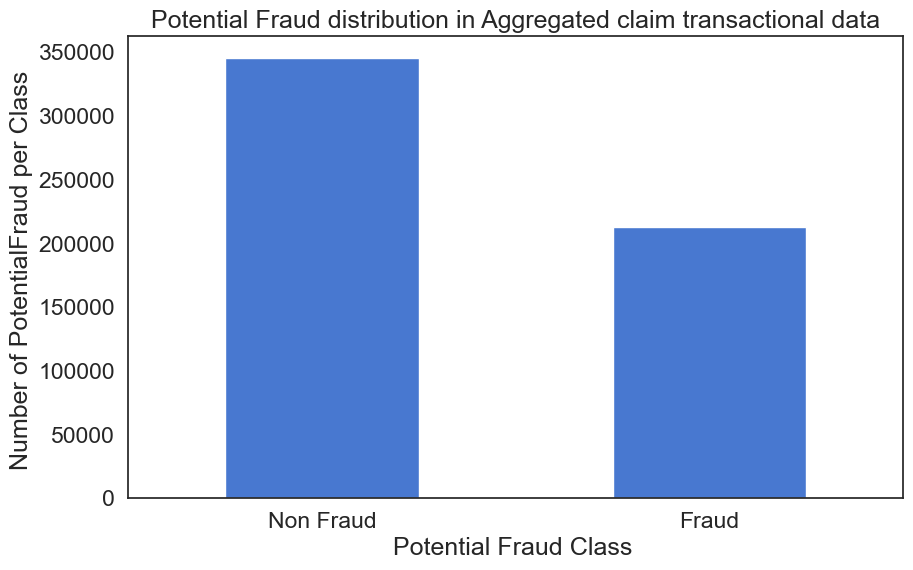

In [52]:
#PLotting the frequencies of fraud and non-fraud Merged transactions in the data
sns.set_style('white',rc={'figure.figsize':(12,8)})
count_classes = pd.value_counts(Train_ProviderWithPatientDetailsdata['PotentialFraud'],sort=True)
print("Percent Distribution of Potential Fraud class:- \n",count_classes*100/len(Train_ProviderWithPatientDetailsdata))
LABELS = ['Non Fraud','Fraud']
count_classes.plot(kind='bar',rot=0,figsize=(10,6))
#Giving titles and labels to the plot
plt.title("Potential Fraud distribution in Aggregated claim transactional data")

plt.xticks(range(2), LABELS)
# plt.legend()
plt.xlabel("Potential Fraud Class ")
plt.ylabel("Number of PotentialFraud per Class ")

plt.savefig('PotentialFraudDistributionInMergedData')


Percent Distribution of Potential Fraud class:- 
 No     90.64695
Yes     9.35305
Name: PotentialFraud, dtype: float64


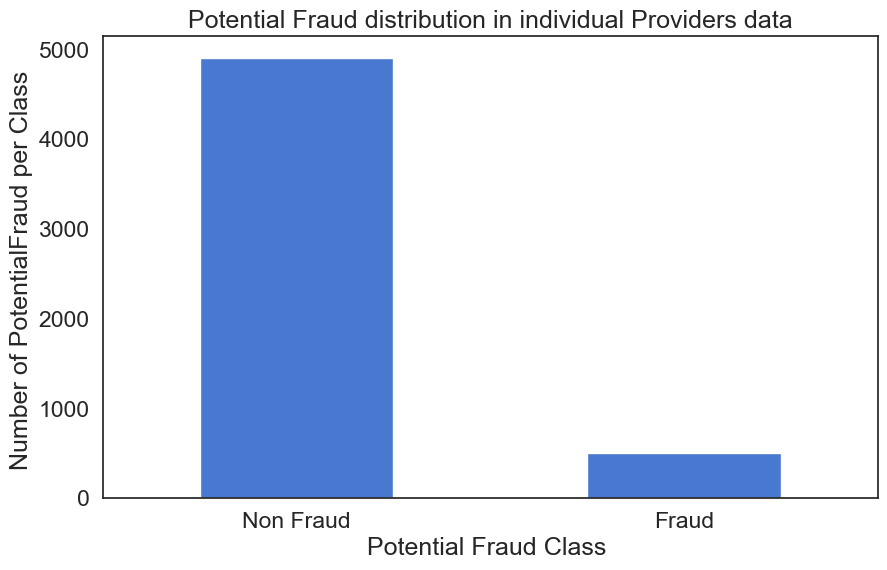

In [53]:

#PLotting the frequencies of fraud and non-fraud transactions in the train data

count_classes_provider = pd.value_counts(train['PotentialFraud'], sort = True)
print("Percent Distribution of Potential Fraud class:- \n",count_classes_provider*100/len(train))
LABELS = ["Non Fraud", "Fraud"]
#Drawing a barplot
count_classes_provider.plot(kind = 'bar', rot=0,figsize=(10,6))

#Giving titles and labels to the plot
plt.title("Potential Fraud distribution in individual Providers data")
plt.xticks(range(2), LABELS)
plt.xlabel("Potential Fraud Class ")
plt.ylabel("Number of PotentialFraud per Class ")
plt.savefig('PotentialFraudDistributionImbalance')

From the above 2 graphs ,we can say that the proportion of fradulent claim transactions are more compared to non fraud providers.So we must get insights from number of claim transactions and amounts involved per - Beneficiary | Beneficiary + Physician |Physician | Diagnosis | Procedure etc...

In [54]:
print('Providers NonFraud|Fraud Class Percent Distribution in Whole dataset :\n',count_classes/len(Train_ProviderWithPatientDetailsdata)*100)

Providers NonFraud|Fraud Class Percent Distribution in Whole dataset :
 No     61.878931
Yes    38.121069
Name: PotentialFraud, dtype: float64


In [55]:
print('Providers NonFraud|Fraud Class Percent Distribution :\n',count_classes_provider/len(train)*100)

Providers NonFraud|Fraud Class Percent Distribution :
 No     90.64695
Yes     9.35305
Name: PotentialFraud, dtype: float64


#### State - ise Percentage Beneficiary Distribution

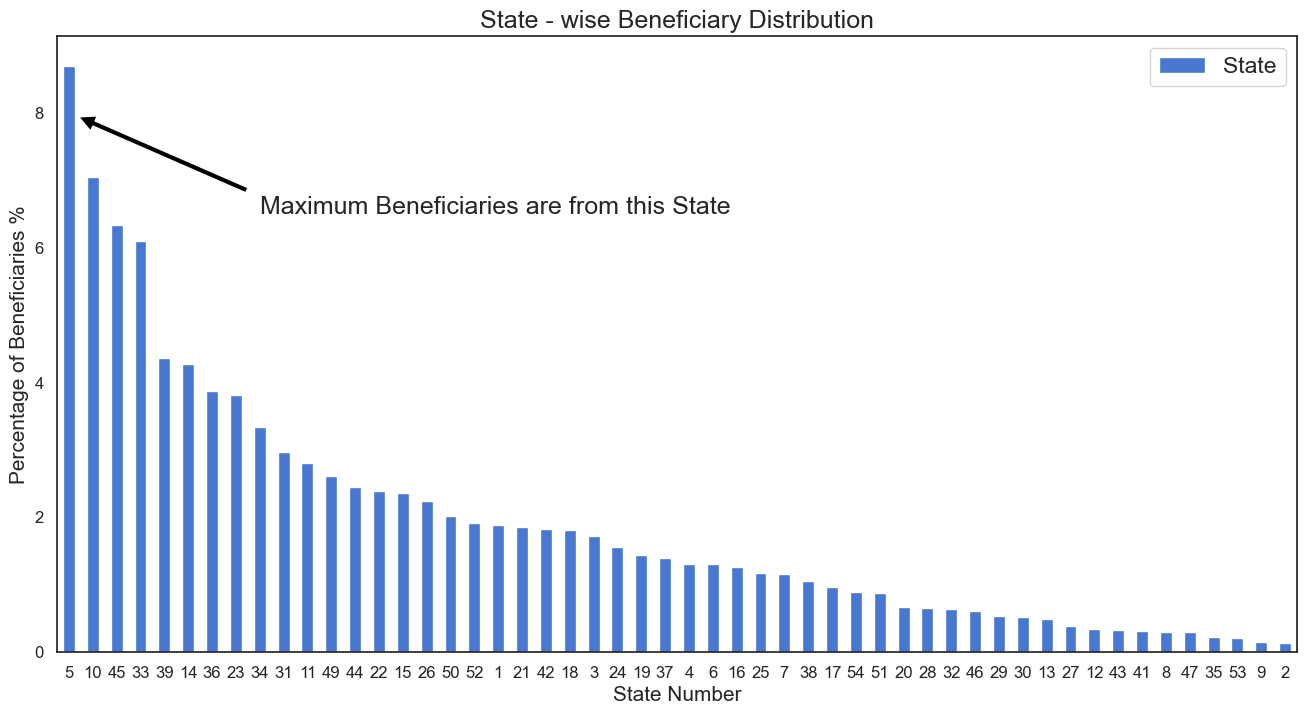

<Figure size 1400x800 with 0 Axes>

In [56]:
#PLotting the frequencies of Statewise beneficiaries
count_States = pd.value_counts(train_Ben['State'], sort = True)
#print("Percent Distribution of Beneficieries per state:- \n",count_States*100/len(Train_Beneficiarydata))

#Drawing a barplot
(count_States*100/len(train_Ben)).plot(kind = 'bar', rot=0,figsize=(16,8),fontsize=12,legend=True)

#Giving titles and labels to the plot

plt.annotate('Maximum Beneficiaries are from this State', xy=(0.01,8), xytext=(8, 6.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

# plt.yticks(np.arange(0,10,2), ('0 %','2 %', '4 %', '6 %', '8 %', '10%'))
plt.yticks(np.arange(0,10,2))
plt.title("State - wise Beneficiary Distribution",fontsize=18)
plt.xlabel("State Number",fontsize=15)
plt.ylabel("Percentage of Beneficiaries "'%',fontsize=15)
plt.show()

plt.savefig('StateWiseBeneficiaryDistribution')

Above Plot shows top states with their beneficiary percentage distribution.States 5,10,45 are top states in terms of beneficiary percentage

Race-wise Percent Distribution of Beneficiaries

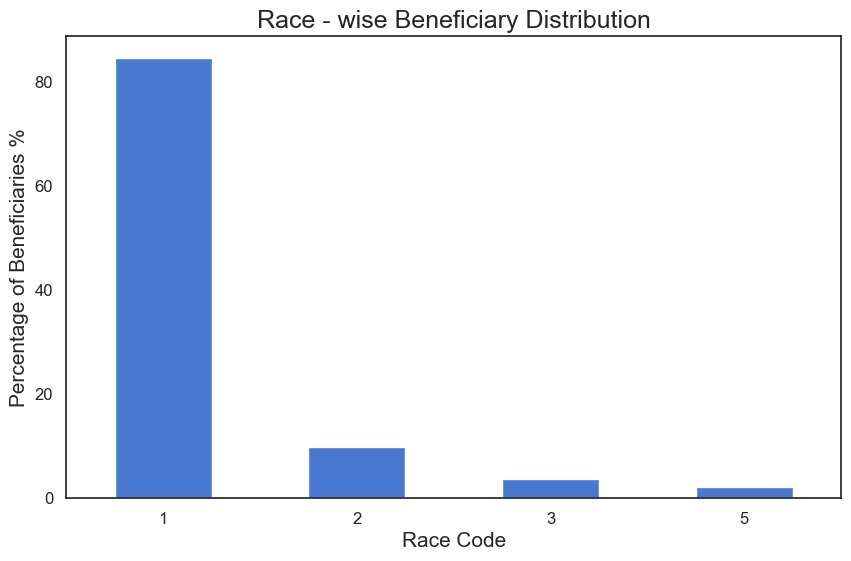

<Figure size 1400x800 with 0 Axes>

In [57]:
#PLotting the frequencies of race-wise beneficiaries
count_Race = pd.value_counts(train_Ben['Race'], sort = True)

#Drawing a barplot
(count_Race*100/len(train_Ben)).plot(kind = 'bar', rot=0,figsize=(10,6),fontsize=12)

#Giving titles and labels to the plot
plt.yticks(np.arange(0,100,20))#, ('0 %','20 %', '40 %', '60 %', '80 %', '100%'))
plt.title("Race - wise Beneficiary Distribution",fontsize=18)
plt.xlabel("Race Code",fontsize=15)
plt.ylabel("Percentage of Beneficiaries "'%',fontsize=15)

plt.show()

plt.savefig('RacewiseBeneficiaryDistribution')

It seems that more than 80% beneficiaries are of same race which is Race 1 which means Maximum population in the dataset originated from same race.There is no race 4 in the dataset

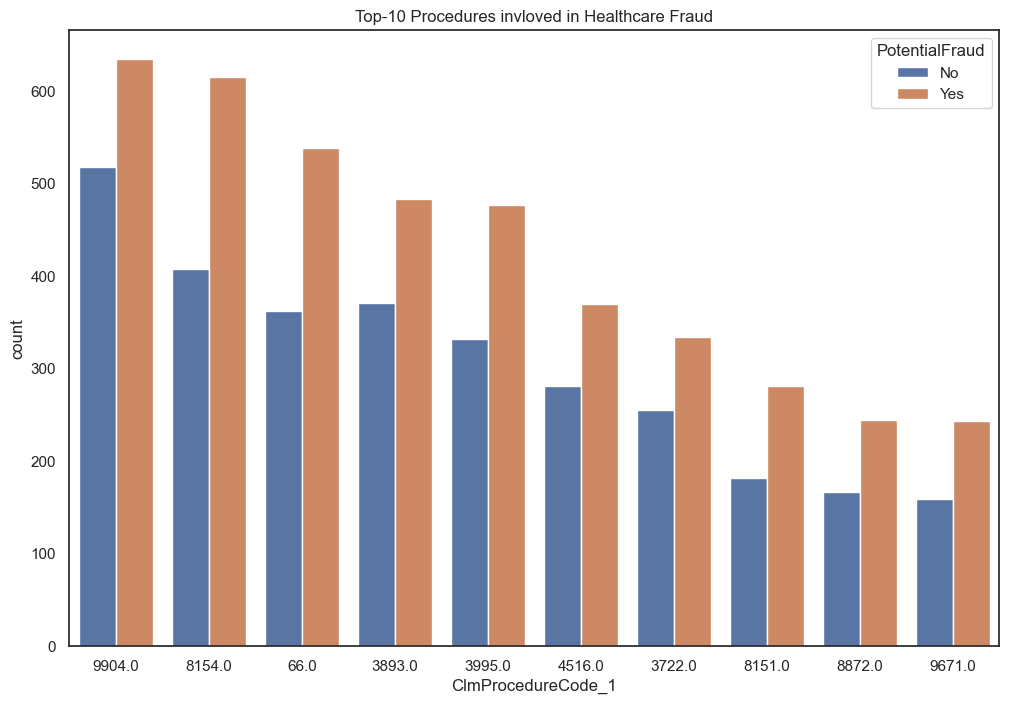

<Figure size 1200x800 with 0 Axes>

In [58]:
# Train_ProviderWithPatientDetailsdata['ClmProcedureCode_1'].unique()
## Lets plot countplot for each fraud non fraud categories

sns.set(rc={'figure.figsize':(12,8)},style='white')

sns.countplot(x='ClmProcedureCode_1',hue='PotentialFraud',data=Train_ProviderWithPatientDetailsdata, order = Train_ProviderWithPatientDetailsdata.ClmProcedureCode_1.value_counts().iloc[:10].index)

plt.title('Top-10 Procedures invloved in Healthcare Fraud')
    
plt.show()

plt.savefig('TopProceduresinvlovedinHealthcareFraud')

From the above plot,we can say that Procedure 9904,8154,66 are top procedures (in terms of money involved).Distribution of fraud and non fraud count shows suspicious transactions involved in them.

##### Top 1 diagnosis code involve in dataset

In [59]:
Train_ProviderWithPatientDetailsdata.columns

Index(['Provider', 'PotentialFraud', 'BeneID', 'ClaimID', 'ClaimStartDt',
       'ClaimEndDt', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode', 'AdmissionDt',
       'DischargeDt', 'DiagnosisGroupCode', 'AdmitForDays', 'DOB', 'DOD',
       'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'Ch

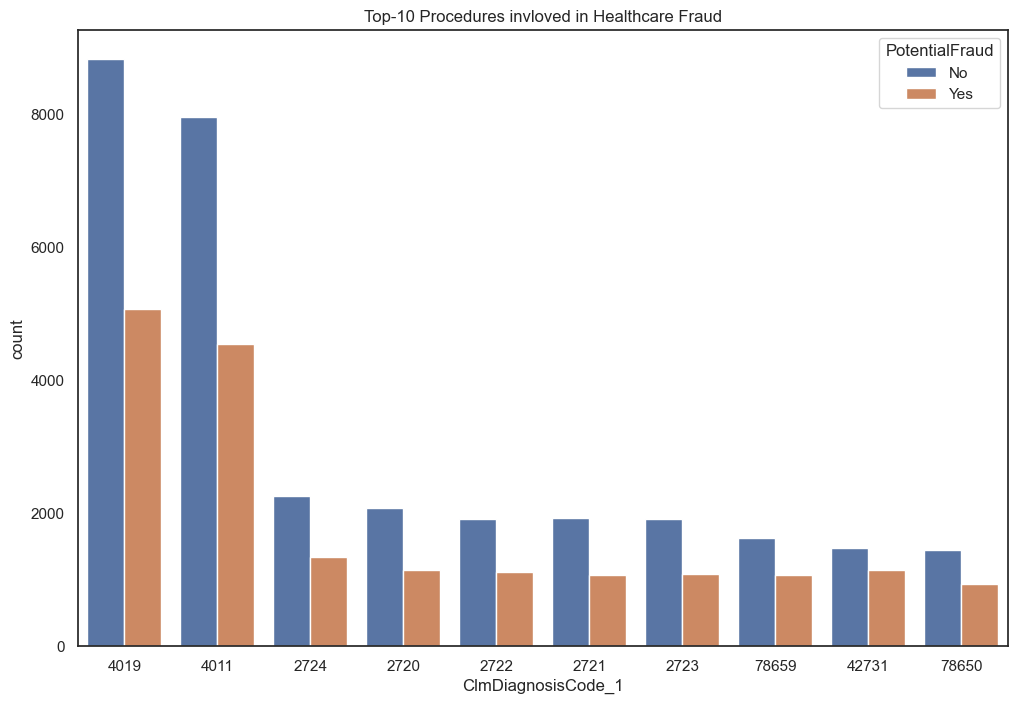

<Figure size 1200x800 with 0 Axes>

In [60]:
# Train_ProviderWithPatientDetailsdata['ClmProcedureCode_1'].unique()
## Lets plot countplot for each fraud non fraud categories

sns.set(rc={'figure.figsize':(12,8)},style='white')

sns.countplot(x='ClmDiagnosisCode_1',hue='PotentialFraud',data=Train_ProviderWithPatientDetailsdata, order = Train_ProviderWithPatientDetailsdata['ClmDiagnosisCode_1'].value_counts().iloc[:10].index)

plt.title('Top-10 Procedures invloved in Healthcare Fraud')
    
plt.show()

plt.savefig('TopProceduresinvlovedinHealthcareFraud')

From the above plot,we can say that diagnosis 4019,4011,2724 are top diagnosis (in terms of money involved).Distribution of fraud and non fraud counts shows suspicious transactions involved in them.

##### Top 20 Attending physician involve in the dataset

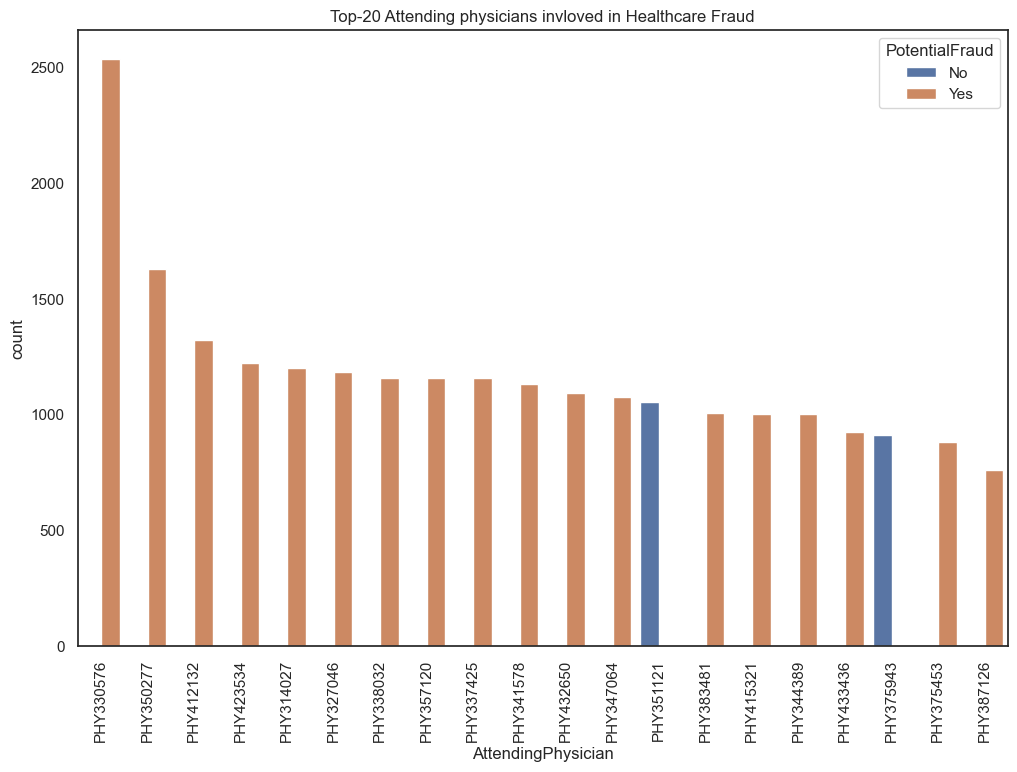

<Figure size 1200x800 with 0 Axes>

In [61]:
### lets plot Top-20 Attending Physicians invloved in Healthcare Fraud 

sns.set(rc={'figure.figsize':(12,8)},style='white')

ax= sns.countplot(x='AttendingPhysician',hue='PotentialFraud',data=Train_ProviderWithPatientDetailsdata
              ,order=Train_ProviderWithPatientDetailsdata.AttendingPhysician.value_counts().iloc[:20].index)

    
plt.title('Top-20 Attending physicians invloved in Healthcare Fraud')
plt.xticks(rotation=90)
plt.show()

plt.savefig('TopAttendingphysiciansinvlovedinHealthcareFraud')

 In the above plot,we see count of involvement of attending physicians.And flags the nature of provider where they are working is whether fraud or non fraud.

IPAnnualDeductibleAmt Vs IPAnnualReimbursementAmt Fraud and non Fraud Categories

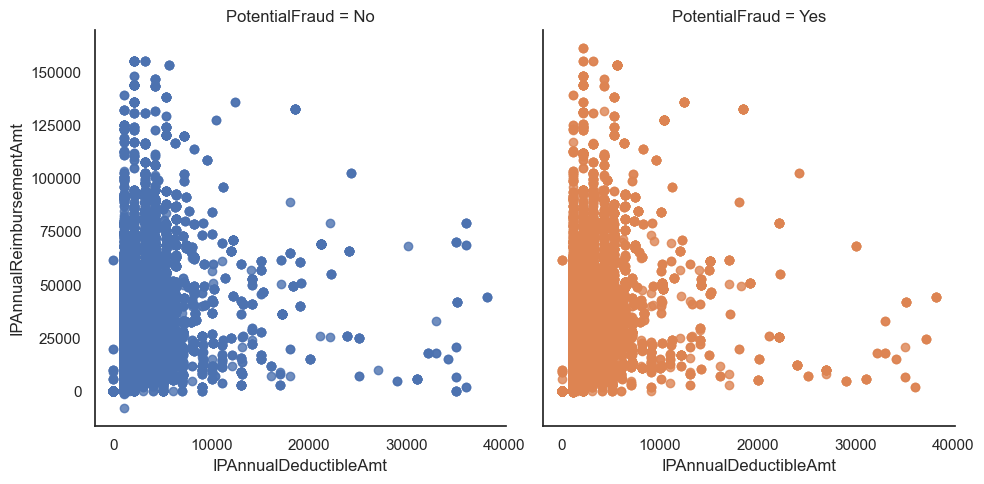

In [62]:
## Lets Plot IPAnnualDeductibleAmt and IPAnnualReimbursementAmt in both fraud and non Fraud Categoories

sns.set(rc={'figure.figsize':(12,8)},style='white')

sns.lmplot(x='IPAnnualDeductibleAmt',y='IPAnnualReimbursementAmt',hue='PotentialFraud',
           col='PotentialFraud',fit_reg=False,data=Train_ProviderWithPatientDetailsdata)


#plt.title('IPAnnualDeductibleAmt and IPAnnualReimbursementAmt in both fraud and non Fraud Categoories')

plt.savefig('IPAnnualDeductibleAmtandIPAnnualReimbursementAmtinbothfraudandnonFraud')

As we see in the above graph,there is no visible difference in IpAnnualDeductibleAmt and IPAnnualReimbursementAmt.

DeductibleAmtPaid Vs InsClaimAmtReimbursed in Fraud and non Fraud Categories

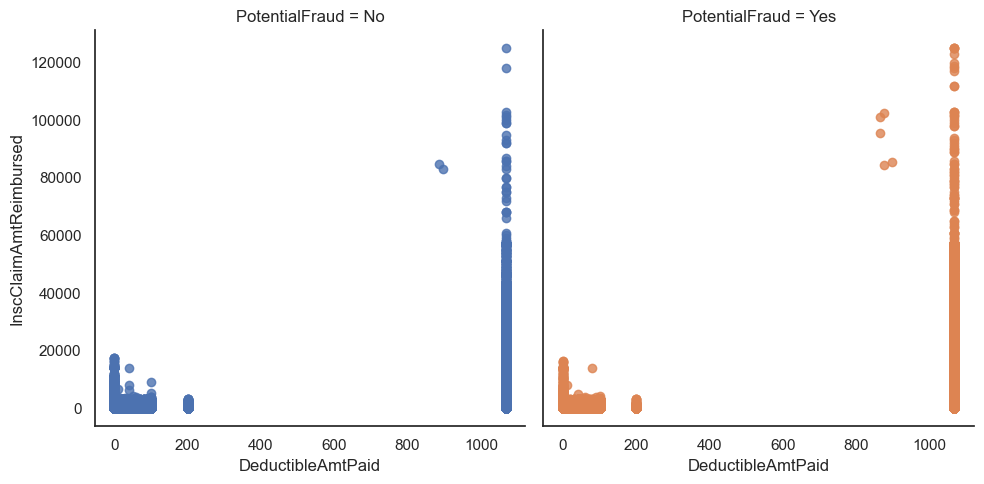

In [63]:
## Lets Plot DeductibleAmtPaid and InsClaimAmtReimbursed in both fraud and non Fraud Categoories

sns.set(rc={'figure.figsize':(12,8)},style='white')

sns.lmplot(x='DeductibleAmtPaid',y='InscClaimAmtReimbursed',hue='PotentialFraud',
           col='PotentialFraud',fit_reg=False,data=Train_ProviderWithPatientDetailsdata)


plt.savefig('DeductibleAmtPaidandInsClaimAmtReimbursed')

We can not differentiate between fraud and non fraud cases based only on DeductibleAmtPaid and InscClaimAmtReimbursed.This lets us derive more features from datasets

##### Insurance Claim Amount Reimbursed Vs Age in Fraud and Non Fraud

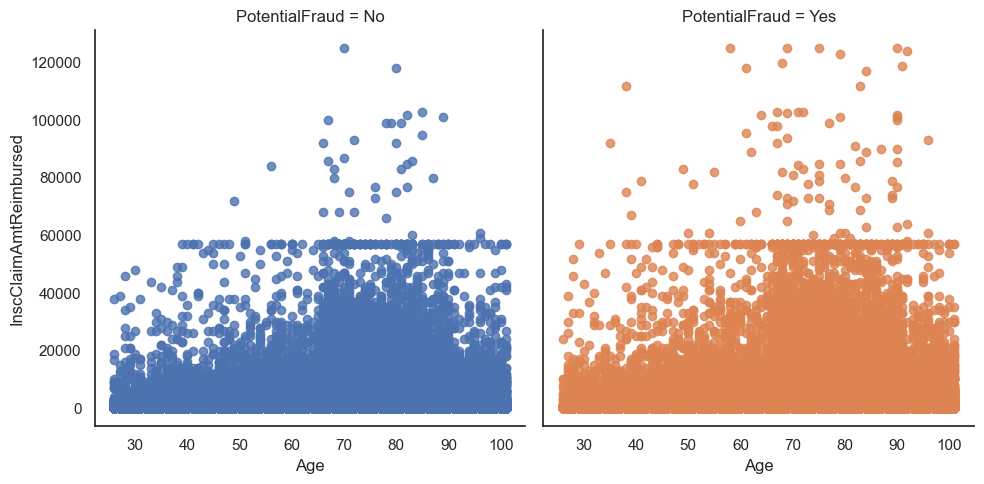

In [64]:
## Lets Plot DeductibleAmtPaid and InsClaimAmtReimbursed in both fraud and non Fraud Categoories

sns.set(rc={'figure.figsize':(12,8)},style='white')

sns.lmplot(x='Age',y='InscClaimAmtReimbursed',hue='PotentialFraud',
           col='PotentialFraud',fit_reg=False,data=Train_ProviderWithPatientDetailsdata)


plt.savefig('AgeInsClaimAmtReimbursed')

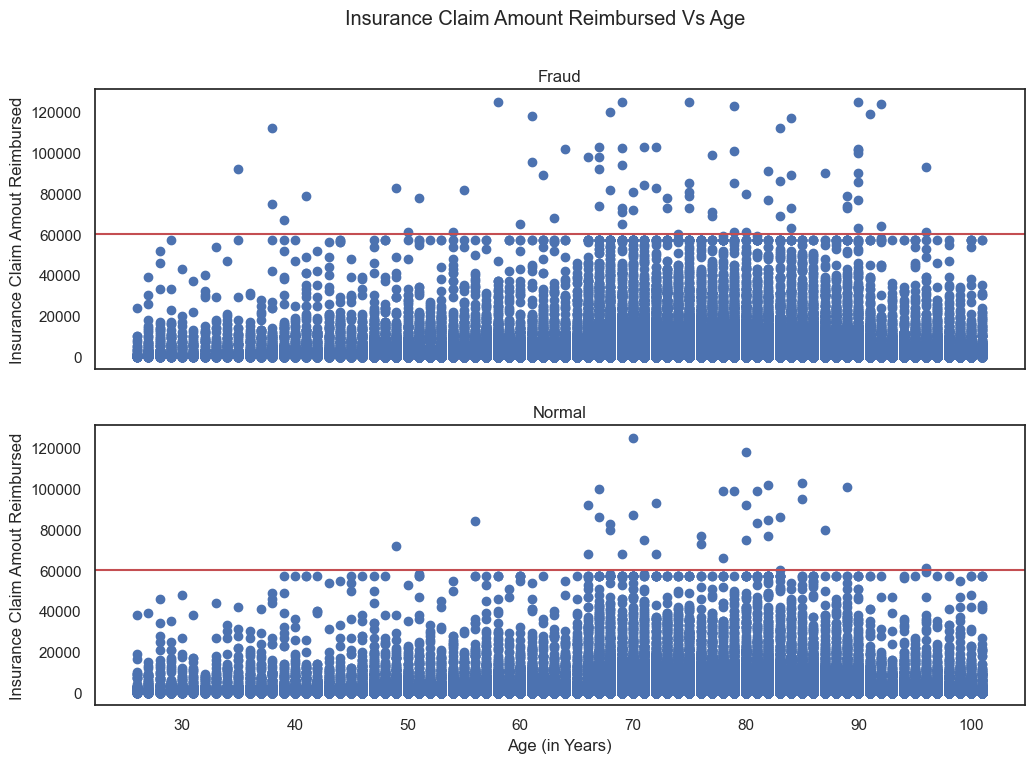

In [65]:
## Let's See Insurance Claim Amount Reimbursed Vs Age
sns.set(rc={'figure.figsize':(12,8)},style='white')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Insurance Claim Amount Reimbursed Vs Age')

ax1.scatter(Train_ProviderWithPatientDetailsdata[Train_ProviderWithPatientDetailsdata.PotentialFraud=='Yes'].Age, 
            Train_ProviderWithPatientDetailsdata[Train_ProviderWithPatientDetailsdata.PotentialFraud=='Yes'].InscClaimAmtReimbursed)
ax1.set_title('Fraud')
ax1.axhline(y=60000,c='r')
ax1.set_ylabel('Insurance Claim Amout Reimbursed')

ax2.scatter(Train_ProviderWithPatientDetailsdata[Train_ProviderWithPatientDetailsdata.PotentialFraud=='No'].Age, 
            Train_ProviderWithPatientDetailsdata[Train_ProviderWithPatientDetailsdata.PotentialFraud=='No'].InscClaimAmtReimbursed)
ax2.set_title('Normal')
ax2.axhline(y=60000,c='r')
ax2.set_xlabel('Age (in Years)')
ax2.set_ylabel('Insurance Claim Amout Reimbursed')

plt.show()
f.savefig('AgeVsClaimAmtReimbursed')

From the above graph,we see that occurance of fraud cases is more frequent in lower age groups(30-70 years) compared to higher age groups(70+ years).Age is one of the important feature for differentiating between fraud abd non fraud behaviour.

#### Feature Engineering Append Train to Test to derive more accurate features.

In [66]:
#Feature Engineering Append Train to Test to derive more accurate features.
# Lets check the last record of Test_ProviderWithPatientDetailsdata

Test_ProviderWithPatientDetailsdata.iloc[[135391]]

,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
135391,PRV57750,BENE150236,CLM675578,2009-11-10,2009-11-10,200,PHY323525,PHY323525,PHY323525,4788,...,1,2,2,2,0,0,290,1120,67.0,0.0


In [67]:
# Lets check the last record of Train_ProviderWithPatientDetailsdata

Train_ProviderWithPatientDetailsdata.iloc[[558210]]

,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
558210,PRV57763,No,BENE158531,CLM701529,2009-11-26,2009-11-26,40,PHY321072,NaN,PHY321072,...,NaN,NaN,NaN,NaN,0,0,3700,240,58.0,0.0


Appending Train data to Test data will help you get good average scores of new features in Test data,as we see not all levels of variables are present in test data compared to train data.So our approach here will be-to append train data to test data ,derive new average features and take only test data to evaluate results.

In [68]:
## Lets create a copy of test data first and merge test with train to get better feature averages

Test_ProviderWithPatientDetailsdata_copy=Test_ProviderWithPatientDetailsdata

In [69]:
#Lets Check shape of copy

print('Shape of Test Copy :-',Test_ProviderWithPatientDetailsdata_copy.shape)

Shape of Test Copy :- (135392, 57)


In [70]:
### We will concat two datasets using columns of Test data only as we dont see target column in Test data.

col_merge=Test_ProviderWithPatientDetailsdata.columns
## Lets add both test and train datasets

Test_ProviderWithPatientDetailsdata=pd.concat([Test_ProviderWithPatientDetailsdata,
                                               Train_ProviderWithPatientDetailsdata[col_merge]])

In [71]:
### Lets verify shape after concatenating

print("Shape of Test After Concatenation",Test_ProviderWithPatientDetailsdata.shape)

print("Expected rows after addition",135392+558211)

Shape of Test After Concatenation (693603, 57)
Expected rows after addition 693603


In [72]:
### Lets check record number 135392 as this will be record from train datasets.
Test_ProviderWithPatientDetailsdata.iloc[[135392]]

,Provider,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,WhetherDead
0,PRV51001,BENE11727,CLM733300,2009-12-17,2009-12-17,20,PHY383007,NaN,PHY383007,5953,...,0.0,0.0,0.0,0.0,0,0,300,110,80.0,0.0


In [73]:
Test_ProviderWithPatientDetailsdata.columns

Index(['Provider', 'BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode', 'AdmissionDt', 'DischargeDt',
       'DiagnosisGroupCode', 'AdmitForDays', 'DOB', 'DOD', 'Gender', 'Race',
       'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov',
       'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depressi

**As we verified that our first record is appended to test data correctly,we are all set to derive Average features grouped according to columns of datasets.

Other than basic explorations and visualizations, we can use certain methods to identify clues of fraud and abuse. One such simple method is 'Grouping based on Similarity'. In this method, we basically group all the records by the ProcedureCodes, DiagnosisCodes,Provider.

For example, if we have a dataset with Procedure codes only for X Procedure, we will then group and check average Amounts involved at each levels of Procedure and analyse the behaviour**

##### Average Features based on grouping variables. Average features grouped by Provider

In [74]:
Train_ProviderWithPatientDetailsdata["PerProviderAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_Age"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['Age'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartACov"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartBCov"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerProviderAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('Provider')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerProviderAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_Age"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['Age'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartACov"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_NoOfMonths_PartBCov"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerProviderAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('Provider')['AdmitForDays'].transform('mean')

In [75]:
#lets check shape

print('Train',Train_ProviderWithPatientDetailsdata.shape)
Train_ProviderWithPatientDetailsdata.iloc[:,-10:].head(2)

print("Test ",Test_ProviderWithPatientDetailsdata.shape)
Test_ProviderWithPatientDetailsdata.iloc[:,-10:].head(4)

Train (558211, 68)
Test  (693603, 67)


,PerProviderAvg_InscClaimAmtReimbursed,PerProviderAvg_DeductibleAmtPaid,PerProviderAvg_IPAnnualReimbursementAmt,PerProviderAvg_IPAnnualDeductibleAmt,PerProviderAvg_OPAnnualReimbursementAmt,PerProviderAvg_OPAnnualDeductibleAmt,PerProviderAvg_Age,PerProviderAvg_NoOfMonths_PartACov,PerProviderAvg_NoOfMonths_PartBCov,PerProviderAvg_AdmitForDays
0,262.390244,1.853659,5180.926829,548.253659,2345.073171,677.95122,72.365854,11.82439,12.0,NaN
1,262.390244,1.853659,5180.926829,548.253659,2345.073171,677.95122,72.365854,11.82439,12.0,NaN
2,262.390244,1.853659,5180.926829,548.253659,2345.073171,677.95122,72.365854,11.82439,12.0,NaN
3,262.390244,1.853659,5180.926829,548.253659,2345.073171,677.95122,72.365854,11.82439,12.0,NaN


In [76]:
## Grouping based on BeneID explains amounts involved per beneficiary.Reason to derive this feature is that one beneficiary 
## can go to multiple providers and can be involved in fraud cases
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerBeneIDAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('BeneID')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerBeneIDAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('BeneID')['AdmitForDays'].transform('mean')

##### Average of other physician

In [77]:
### Average features grouped by OtherPhysician.

Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['AdmitForDays'].transform('mean')

Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOtherPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('OtherPhysician')['AdmitForDays'].transform('mean')

##### Average features grouped by OperatingPhysician

In [78]:
##Average features grouped by OperatingPhysician

Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['AdmitForDays'].transform('mean')

Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerOperatingPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('OperatingPhysician')['AdmitForDays'].transform('mean')

##### Average by attendin Physician

In [79]:

### Average features grouped by AttendingPhysician   

Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerAttendingPhysicianAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('AttendingPhysician')['AdmitForDays'].transform('mean')

##### Average features grouped by DiagnosisGroupCode

In [80]:
###  Average features grouped by DiagnosisGroupCode  

Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['AdmitForDays'].transform('mean')

Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerDiagnosisGroupCodeAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('DiagnosisGroupCode')['AdmitForDays'].transform('mean')

##### Average features grouped by ClmAdmitDiagnosisCode

In [81]:
### Average features grouped by ClmAdmitDiagnosisCode 

Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['AdmitForDays'].transform('mean')

Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmAdmitDiagnosisCodeAvg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmAdmitDiagnosisCode')['AdmitForDays'].transform('mean')

##### Average features grouped by ClmProcedureCode_1

In [82]:
### Average features grouped by ClmProcedureCode_1 

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_1Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_1')['AdmitForDays'].transform('mean')

In [83]:
### Average features grouped by ClmProcedureCode_2

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_2Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_2')['AdmitForDays'].transform('mean')

In [84]:
###  Average features grouped by ClmProcedureCode_3

Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmProcedureCode_3Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmProcedureCode_3')['AdmitForDays'].transform('mean')

##### verage features grouped by ClmDiagnosisCode_1

In [85]:
### Average features grouped by ClmDiagnosisCode_1 

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_1Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_1')['AdmitForDays'].transform('mean')

##### Average features grouped by ClmDiagnosisCode_2

In [86]:
###  Average features grouped by ClmDiagnosisCode_2

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_2Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_2')['AdmitForDays'].transform('mean')

##### Average features grouped by ClmDiagnosisCode_3

In [87]:
###  Average features grouped by ClmDiagnosisCode_3

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_3Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_3')['AdmitForDays'].transform('mean')

Average features grouped by ClmDiagnosisCode_4

In [88]:
###  Average features grouped by ClmDiagnosisCode_4

Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_DeductibleAmtPaid"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_AdmitForDays"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['AdmitForDays'].transform('mean')


Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_InscClaimAmtReimbursed"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['InscClaimAmtReimbursed'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_DeductibleAmtPaid"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['DeductibleAmtPaid'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualReimbursementAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualReimbursementAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_OPAnnualDeductibleAmt"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['OPAnnualDeductibleAmt'].transform('mean')
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_AdmitForDays"]=Test_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['AdmitForDays'].transform('mean')

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\3766079207.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualReimbursementAmt"]=Train_ProviderWithPatientDetailsdata.groupby('ClmDiagnosisCode_4')['IPAnnualReimbursementAmt'].transform('mean')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\3766079207.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Train_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_IPAnnualDeductibleAmt"]=Train_Provider

In [89]:
Test_ProviderWithPatientDetailsdata["PerClmDiagnosisCode_4Avg_AdmitForDays"]

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
558206    5.0
558207    NaN
558208    NaN
558209    NaN
558210    NaN
Name: PerClmDiagnosisCode_4Avg_AdmitForDays, Length: 693603, dtype: float64

#### Claims are filed by Provider,so fraud can be organized crime.So we will check ClmCounts filed by Providers and when pairs like Provider +BeneID, Provider+Attending Physician, Provider+ClmAdmitDiagnosisCode, Provider+ClmProcedureCode_1,Provider+ClmDiagnosisCode_1 are together.

Average Feature based on grouping based on combinations of different variables

In [90]:
### Average Feature based on grouping based on combinations of different variables

Train_ProviderWithPatientDetailsdata["ClmCount_Provider"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_AttendingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_OtherPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_OperatingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmAdmitDiagnosisCode"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_2"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_3"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_4"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_5"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_2"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_3"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_4"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_5"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_6"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_7"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_8"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_9"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_DiagnosisGroupCode"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OtherPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OperatingPhysician"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')


Test_ProviderWithPatientDetailsdata["ClmCount_Provider"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_AttendingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_OtherPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_OperatingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmAdmitDiagnosisCode"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_2"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_3"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_4"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmProcedureCode_5"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_2"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_3"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_4"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_5"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_6"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_7"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_8"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_9"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_DiagnosisGroupCode"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OtherPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_OperatingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
Test_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\1044997534.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Train_ProviderWithPatientDetailsdata["ClmCount_Provider"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\1044997534.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Train_ProviderWithPatientDetailsdata["ClmCount_Provider_BeneID"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','BeneID'])['ClaimID'].transform('co

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\1044997534.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_6"]=Train_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\1044997534.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Train_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_7"]=Train_ProviderWithPatientDetailsdata.g

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\1044997534.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Test_ProviderWithPatientDetailsdata["ClmCount_Provider_AttendingPhysician"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\1044997534.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Test_ProviderWithPatientDetailsdata["ClmCount_Provider_OtherPhysician"]=Test_ProviderWithPatientDetailsdata.groupby([

C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\1044997534.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_8"]=Test_ProviderWithPatientDetailsdata.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
C:\Users\Sheriff\AppData\Local\Temp\ipykernel_10308\1044997534.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Test_ProviderWithPatientDetailsdata["ClmCount_Provider_ClmDiagnosisCode_9"]=Test_ProviderWithPatientDetailsdata.group

In [91]:
## Lets Check Shape after creating new features.

print('Train_ProviderWithPatientDetailsdata shape-',Train_ProviderWithPatientDetailsdata.shape)
print('Test_ProviderWithPatientDetailsdata shape-',Test_ProviderWithPatientDetailsdata.shape)

Train_ProviderWithPatientDetailsdata shape- (558211, 188)
Test_ProviderWithPatientDetailsdata shape- (693603, 187)


In [92]:
 ## Lets Check unique values of ICD Diagnosis Codes

diagnosiscode_2chars=Train_ProviderWithPatientDetailsdata['ClmDiagnosisCode_1'].astype(str).str[0:2]

diagnosiscode_2chars.unique()

array(['59', '78', 'V4', '29', '03', '51', 'na', '71', 'V1', '27', '42',
       'V7', '24', '41', '56', '79', '04', '35', '85', 'V5', '72', '44',
       '45', '18', '60', '50', '57', '40', '16', '25', '68', '15', '82',
       '28', '61', '47', '99', '20', '70', '33', '31', '49', '88', '48',
       '53', '43', '91', '55', '00', '58', '73', '46', '19', '17', 'V0',
       '34', 'V6', '62', 'V8', '11', '36', '83', 'E8', '02', '32', '52',
       '38', '23', '84', '37', 'V2', '87', '30', '90', '21', '12', '92',
       '39', '63', '69', '64', '81', '89', '95', '80', '22', '07', '06',
       '93', '94', '54', '26', '05', '13', '74', '14', '98', '08', '97',
       '75', '66', 'E9', '09', '96', '10', '77', '86', '65', '67', '01',
       '76'], dtype=object)

##### Data Preprocessing

Impute Numeric columns with 0's.

In [93]:
numeric_features = [i for i in Train_ProviderWithPatientDetailsdata.columns if Train_ProviderWithPatientDetailsdata[i].dtypes!='O']

In [94]:
Train_ProviderWithPatientDetailsdata[numeric_features].head()

,InscClaimAmtReimbursed,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,AdmissionDt,DischargeDt,...,ClmCount_Provider_ClmDiagnosisCode_9,ClmCount_Provider_DiagnosisGroupCode,ClmCount_Provider_BeneID_AttendingPhysician,ClmCount_Provider_BeneID_OtherPhysician,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1
0,20,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaT,NaT,...,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN
1,700,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaT,NaT,...,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN
2,900,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaT,NaT,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN
3,500,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaT,NaT,...,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,1.0,NaN
4,36000,NaN,NaN,NaN,NaN,NaN,NaN,1068.0,2009-07-04,2009-07-08,...,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN


In [95]:
Train_ProviderWithPatientDetailsdata[numeric_features].isna().sum()

InscClaimAmtReimbursed                                                 0
ClmProcedureCode_1                                                534901
ClmProcedureCode_2                                                552721
ClmProcedureCode_3                                                557242
ClmProcedureCode_4                                                558093
                                                                   ...  
ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1     11924
ClmCount_Provider_BeneID_OperatingPhysician                       443764
ClmCount_Provider_BeneID_ClmProcedureCode_1                       534901
ClmCount_Provider_BeneID_ClmDiagnosisCode_1                        10453
ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1    534901
Length: 166, dtype: int64

In [96]:
##### Lets impute numeric columns with 0

cols1 = Train_ProviderWithPatientDetailsdata.select_dtypes([np.number]).columns
cols2 = Train_ProviderWithPatientDetailsdata.select_dtypes(exclude = [np.number]).columns

# Train_ProviderWithPatientDetailsdata[cols1] = Train_ProviderWithPatientDetailsdata[cols1].fillna(value=0)
# Test_ProviderWithPatientDetailsdata[cols1]=Test_ProviderWithPatientDetailsdata[cols1].fillna(value=0)
# print('Test_ProviderWithPatientDetailsdata shape:',Test_ProviderWithPatientDetailsdata.shape)

In [97]:
cols1,cols2

(Index(['InscClaimAmtReimbursed', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
        'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
        'ClmProcedureCode_6', 'DeductibleAmtPaid', 'AdmitForDays', 'Gender',
        ...
        'ClmCount_Provider_ClmDiagnosisCode_9',
        'ClmCount_Provider_DiagnosisGroupCode',
        'ClmCount_Provider_BeneID_AttendingPhysician',
        'ClmCount_Provider_BeneID_OtherPhysician',
        'ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1',
        'ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1',
        'ClmCount_Provider_BeneID_OperatingPhysician',
        'ClmCount_Provider_BeneID_ClmProcedureCode_1',
        'ClmCount_Provider_BeneID_ClmDiagnosisCode_1',
        'ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1'],
       dtype='object', length=162),
 Index(['Provider', 'PotentialFraud', 'BeneID', 'ClaimID', 'ClaimStartDt',
        'ClaimEndDt', 'AttendingPhysician', 'OperatingPhys

In [98]:
Train_ProviderWithPatientDetailsdata[cols1] = Train_ProviderWithPatientDetailsdata[cols1].fillna(value=0)
Test_ProviderWithPatientDetailsdata[cols1]=Test_ProviderWithPatientDetailsdata[cols1].fillna(value=0)
print('Test_ProviderWithPatientDetailsdata shape:',Test_ProviderWithPatientDetailsdata.shape)

Test_ProviderWithPatientDetailsdata shape: (693603, 187)


##### Feature Selection

In [99]:
# Lets remove unnecessary columns ,as we grouped based on these columns and derived maximum infromation from them.

cols=Train_ProviderWithPatientDetailsdata.columns
cols[:58]

remove_these_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'ClmAdmitDiagnosisCode', 'AdmissionDt',
       'DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD',
        'State', 'County']

Train_category_removed=Train_ProviderWithPatientDetailsdata.drop(axis=1,columns=remove_these_columns)
Test_category_removed=Test_ProviderWithPatientDetailsdata.drop(axis=1,columns=remove_these_columns)


In [100]:
## Lets Check shape and missing values

print('Train Shape :',Train_category_removed.shape)
print('Test Shape : ',Test_category_removed.shape)
print("Train Missing Values",Train_category_removed.isnull().sum().sum())
print("Test Missing Values",Test_category_removed.isnull().sum().sum())

Train Shape : (558211, 157)
Test Shape :  (693603, 156)
Train Missing Values 0
Test Missing Values 0


##### Type Conversion

In [101]:
## Lets Convert types of gender and race to categorical.

Train_category_removed.Gender=Train_category_removed.Gender.astype('category')
Test_category_removed.Gender=Test_category_removed.Gender.astype('category')

Train_category_removed.Race=Train_category_removed.Race.astype('category')
Test_category_removed.Race=Test_category_removed.Race.astype('category')

In [102]:
#cols1 = Train_ProviderWithPatientDetailsdata.select_dtypes([np.number]).columns
cols2 = Train_ProviderWithPatientDetailsdata.select_dtypes(exclude = [np.number]).columns

In [103]:
cols2

Index(['Provider', 'PotentialFraud', 'BeneID', 'ClaimID', 'ClaimStartDt',
       'ClaimEndDt', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmAdmitDiagnosisCode',
       'AdmissionDt', 'DischargeDt', 'DiagnosisGroupCode', 'DOB', 'DOD',
       'RenalDiseaseIndicator'],
      dtype='object')

##### DummyFicationss

In [104]:
# Lets create dummies for categorrical columns.

Train_category_removed=pd.get_dummies(Train_category_removed,columns=['Gender','Race'],drop_first=True)
Test_category_removed=pd.get_dummies(Test_category_removed,columns=['Gender','Race'],drop_first=True)

onvert Target values to 1 and 0,wher '1' means Yes and '0' means No

In [105]:
Train_category_removed.PotentialFraud.replace(['Yes','No'],['1','0'],inplace=True)
Train_category_removed.head()
Train_category_removed.PotentialFraud=Train_category_removed.PotentialFraud.astype('int64')
Train_category_removed.PotentialFraud.dtypes
Train_category_removed.PotentialFraud.min()

0

In [106]:
Train_category_removed.PotentialFraud.max()

1

Select only Test related data from merged data

In [107]:
print('Test Shape before removing',Test_category_removed.shape)

Test Shape before removing (693603, 158)


In [108]:
Test_category_removed=Test_category_removed.iloc[:135392]   ##Remove train data from appended test data

In [109]:
Test_category_removed.tail()   # Check last 5 records.

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
135387,PRV57750,1300,0.0,0.0,0,12,12,2.0,1.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0
135388,PRV57750,10,0.0,0.0,0,12,12,2.0,2.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0,0
135389,PRV57750,200,0.0,0.0,0,12,12,2.0,2.0,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1,1,0,0
135390,PRV57750,2300,0.0,0.0,0,12,12,1.0,2.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1,0,0,0
135391,PRV57750,200,0.0,0.0,0,12,12,2.0,1.0,2.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1,0,1,0


In [110]:
print('Test Shape before removing',Test_category_removed.shape)

Test Shape before removing (135392, 158)


Data Aggregation to the Providers level

In [111]:
### Lets aggregate claims data to unique providers.

Train_category_removed_groupedbyProv_PF=Train_category_removed.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
Test_category_removed_groupedbyProv_PF=Test_category_removed.groupby(['Provider'],as_index=False).agg('sum')

In [112]:
print('Providers in Train:' ,Train_category_removed_groupedbyProv_PF.shape)
print('Providers in Test :',Test_category_removed_groupedbyProv_PF.shape)

Providers in Train: (5410, 158)
Providers in Test : (1353, 157)


In [113]:
Train_category_removed_groupedbyProv_PF.head(3)
Test_category_removed_groupedbyProv_PF.head(3)

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
0,PRV51002,53790,380.0,0.0,2424,2460,331.0,302.0,338.0,385.0,...,0.0,202.0,30.0,0.0,204.0,0.0,134.0,30.0,2.0,4.0
1,PRV51006,30720,0.0,0.0,1224,1224,169.0,135.0,154.0,189.0,...,0.0,99.0,26.0,0.0,99.0,0.0,59.0,26.0,0.0,0.0
2,PRV51009,27230,1238.0,8.0,468,468,70.0,61.0,59.0,77.0,...,2.0,40.0,24.0,2.0,41.0,2.0,23.0,6.0,0.0,0.0


### Train Validation Split

In [114]:
print('Train shape:',Train_category_removed_groupedbyProv_PF.shape)

Train shape: (5410, 158)


In [115]:
print('Train shape:',Train_category_removed_groupedbyProv_PF.shape)

Train shape: (5410, 158)


In [116]:
## Lets Seperate out Target and providers from independent variables.Create Target column y.

X=Train_category_removed_groupedbyProv_PF.drop(axis=1,columns=['Provider','PotentialFraud'])
y=Train_category_removed_groupedbyProv_PF['PotentialFraud']

#### Standardization

In [117]:
## Lets apply StandardScaler and transform values to its z form,where 99.7% values range between -3 to 3.
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
sc=StandardScaler()   # MinMaxScaler
sc.fit(X)
X_std=sc.transform(X)

X_teststd=sc.transform(Test_category_removed_groupedbyProv_PF.iloc[:,1:])   #Apply Standard Scaler to unseen data as well.

#print(X_std[0:3,:])
#print(X_teststd[0:3,:])

In [118]:
print('X Shape:',X_std.shape)

X Shape: (5410, 156)


##### Lets Split data in train and validation

In [119]:
## 'stratify=y' will make sure equal distribution of yes:no in both train and validation

X_train,X_val,y_train,y_val = train_test_split(X_std,y,test_size=0.3,random_state=101,stratify=y,shuffle=True)

In [120]:
print('X_train :',X_train.shape)
print('y_train :',y_train.shape)

print('X_val :',X_val.shape)
print('y_val :',y_val.shape)

X_train : (3787, 156)
y_train : (3787,)
X_val : (1623, 156)
y_val : (1623,)


In [121]:
print('X_teststd',X_teststd.shape)

X_teststd (1353, 156)


##### Model Building

Logistic regression**

In [122]:
import warnings     # for supressing a warning when importing large files
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegressionCV

log = LogisticRegressionCV(cv=10,class_weight='balanced',random_state=123) 
# The "balanced" mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
#in the input data as ``n_samples / (n_classes * np.bincount(y))``

log.fit(X_train,y_train)

LogisticRegressionCV(class_weight='balanced', cv=10, random_state=123)

In [123]:
## Lets predict probability of 1 and 0 for X_train and X_val

log_train_pred_probability=log.predict_proba(X_train)
log_val_pred_probability=log.predict_proba(X_val)

Logistic Regression Model Prediction for Train and Validation

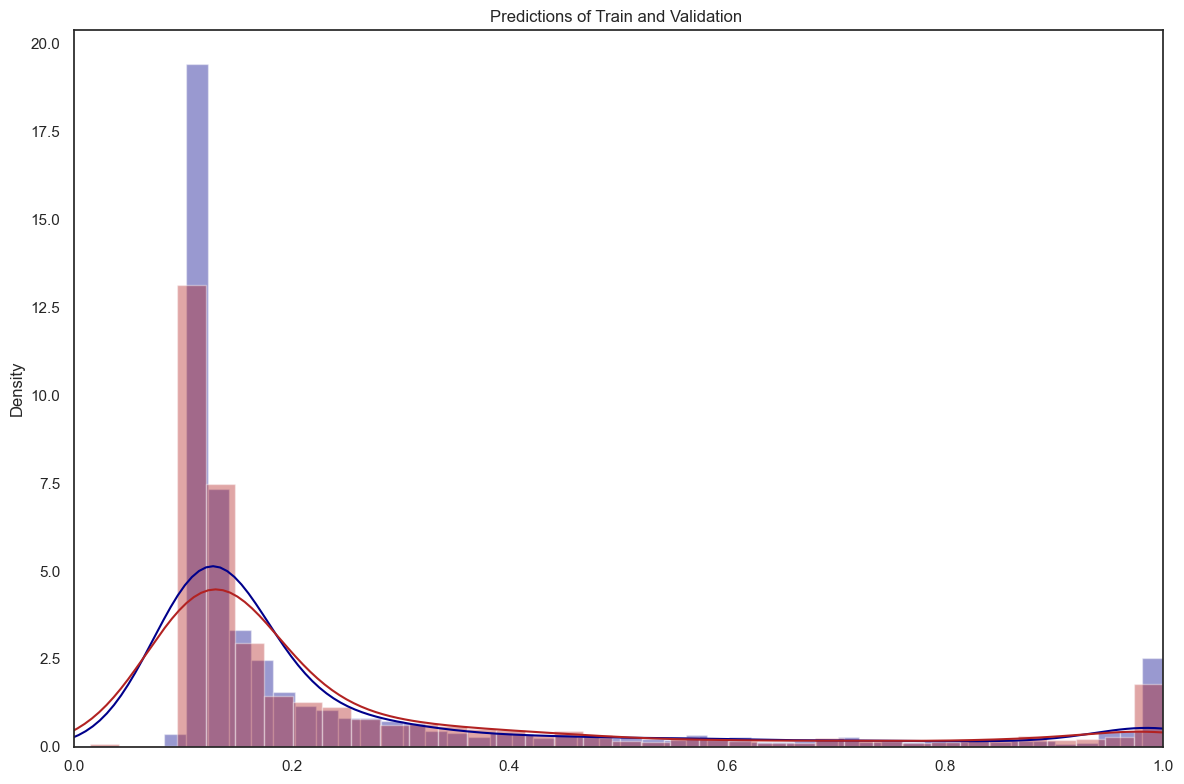

In [124]:
# Lets compare model prediction performance on train and Validation both.

fig = plt.figure(figsize=(12,8))

sns.distplot(log.predict_proba(X_train)[:,1],color='darkblue')
sns.distplot(log.predict_proba(X_val)[:,1],color='firebrick')
plt.title('Predictions of Train and Validation ')
plt.xlim([0, 1])

plt.tight_layout()

plt.show()

### Logistic regression : ROC Curve

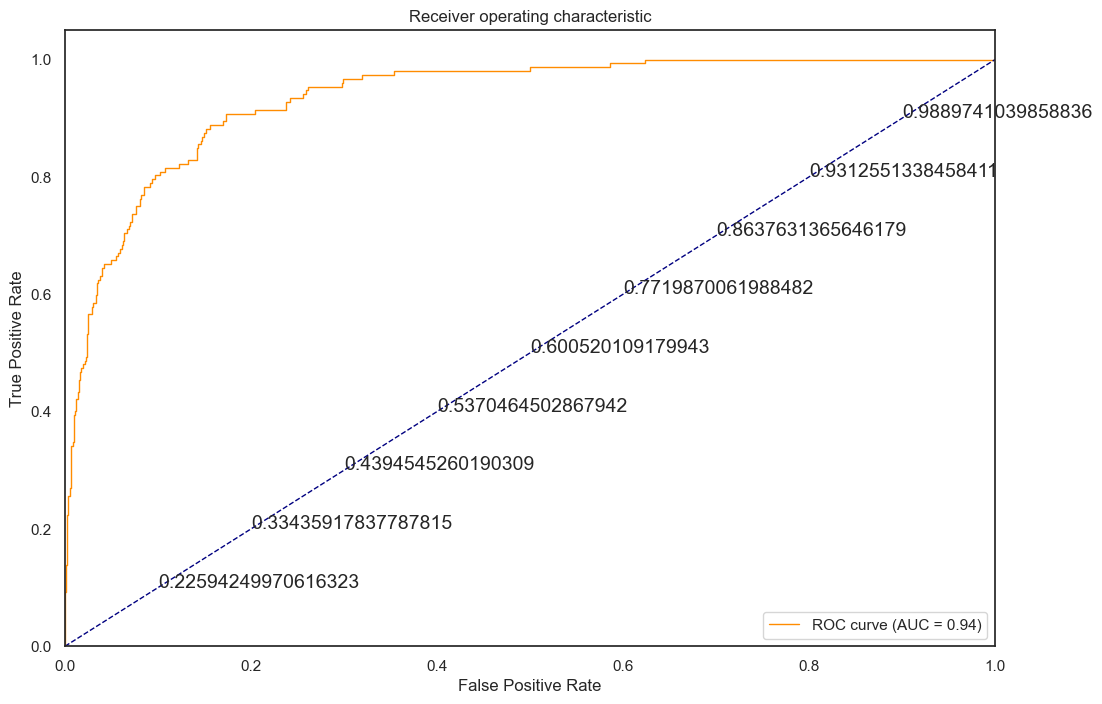

In [125]:
from sklearn.metrics import roc_curve, auc,precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_val,log.predict_proba(X_val)[:,1])         #log_val_pred_probability[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [126]:
fpr, tpr, thresholds =roc_curve(y_val, log.predict_proba(X_val)[:,1],pos_label=1)     #log_val_pred_probability[:,1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.935570


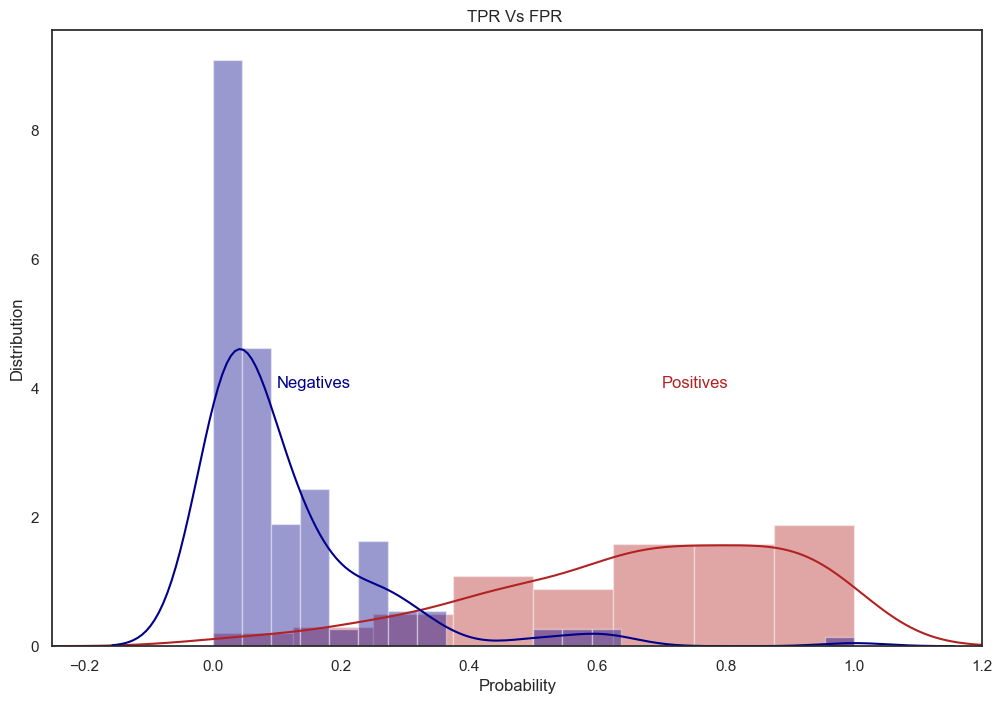

In [127]:
# Logistic Regression : TPR Vs FPR

## Lets Check Tpr vs fpr distribution.

fig = plt.figure(figsize=(12,8))

sns.distplot(tpr,color='firebrick')

sns.distplot(fpr,color='darkblue')
plt.title('TPR Vs FPR ')
plt.xlim([-.25, 1.2])

plt.text(0.1,4,'Negatives',color='darkblue')
plt.text(0.7,4,'Positives',color='firebrick')
plt.xlabel('Probability')
plt.ylabel('Distribution')
plt.show()

### Threshold

Probability Thresholding

**Thresholding Probabilities:

If the algorithm returns probabilities (or some other score), thresholding can be applied after a model has been built. Essentially you change the classification threshold from 50-50 to an appropriate trade-off level. This typically can be optimized by generated a curve of the evaluation metric (e.g. F-measure). The limitation here is that you are making absolute trade-offs. Any modification in the cutoff will in turn decrease the accuracy of predicting the other class.**

In [128]:
## Lets Set probability Threshold to 0.60

log_train_pred_60=(log.predict_proba(X_train)[:,1]>0.60).astype(bool)
log_val_pred_60=(log.predict_proba(X_val)[:,1]>0.60).astype(bool)   # set threshold as 0.60

In [129]:
#Confusion matrix, Accuracy, sensitivity and specificity

from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,roc_auc_score,f1_score,auc

cm0 = confusion_matrix(y_train, log_train_pred_60,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_val, log_val_pred_60,labels=[1,0])
print('Confusion Matrix Val: \n', cm1)

total0=sum(sum(cm0))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm0[0,0]+cm0[1,1])/total0
print ('Accuracy Train: ', accuracy0)

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Val: ', accuracy1)

sensitivity0 = cm0[0,0]/(cm0[0,0]+cm0[0,1])
print('Sensitivity Train : ', sensitivity0 )

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity Val: ', sensitivity1 )


specificity0 = cm0[1,1]/(cm0[1,0]+cm0[1,1])
print('Specificity Train: ', specificity0)

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity Val: ', specificity1)

KappaValue=cohen_kappa_score(y_val, log_val_pred_60)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_val, log_val_pred_60)

print("AUC         :",AUC)

print("F1-Score Train  : ",f1_score(y_train, log_train_pred_60))

print("F1-Score Val  : ",f1_score(y_val, log_val_pred_60))

Confusion Matrix Train : 
 [[ 271   83]
 [ 198 3235]]
Confusion Matrix Val: 
 [[ 103   49]
 [  90 1381]]
Accuracy Train:  0.9257987853181938
Accuracy Val:  0.9143561306223044
Sensitivity Train :  0.7655367231638418
Sensitivity Val:  0.6776315789473685
Specificity Train:  0.9423244975240315
Specificity Val:  0.938817131203263
Kappa Value : 0.5499428443751084
AUC         : 0.8082243550753158
F1-Score Train  :  0.6585662211421628
F1-Score Val  :  0.5971014492753624


In [130]:
## Lets predict on Test data

log_test_pred_60 = (log.predict_proba(X_teststd)[:,1]>0.60).astype(bool)
log_test_pred=pd.DataFrame(log_test_pred_60)
log_test_pred.head(2)

,0
0,True
1,True


In [131]:
# Lets Replace 1 with Yes and 0 With No
Replacement = {1:'Yes',0:'No'}

Labels=log_test_pred[0].apply(lambda x : Replacement[x])
Labels.value_counts()    #Check count of Predictions

No     787
Yes    566
Name: 0, dtype: int64

In [132]:
## Submission file

submission_log=pd.DataFrame({"Provider":Test_category_removed_groupedbyProv_PF.Provider})
submission_log['PotentialFraud']=Labels
submission_log.shape

(1353, 2)

In [133]:
#write Submission file

submission_log.to_csv("Submission_Logistic_Regression_F1_60_Threshold_60Prcnt.csv",index=False)

In [134]:
submission_log.PotentialFraud.value_counts()

No     787
Yes    566
Name: PotentialFraud, dtype: int64

#### Random Forest

In [135]:
## Lets Apply Random Forest 
from sklearn.ensemble import RandomForestClassifier

In [136]:
rfc = RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=123,max_depth=4)   # We will set max_depth =4

In [137]:
rfc.fit(X_train,y_train)  #fit the model

RandomForestClassifier(class_weight='balanced', max_depth=4, n_estimators=500,
                       random_state=123)

### Random Forest ROC Curve

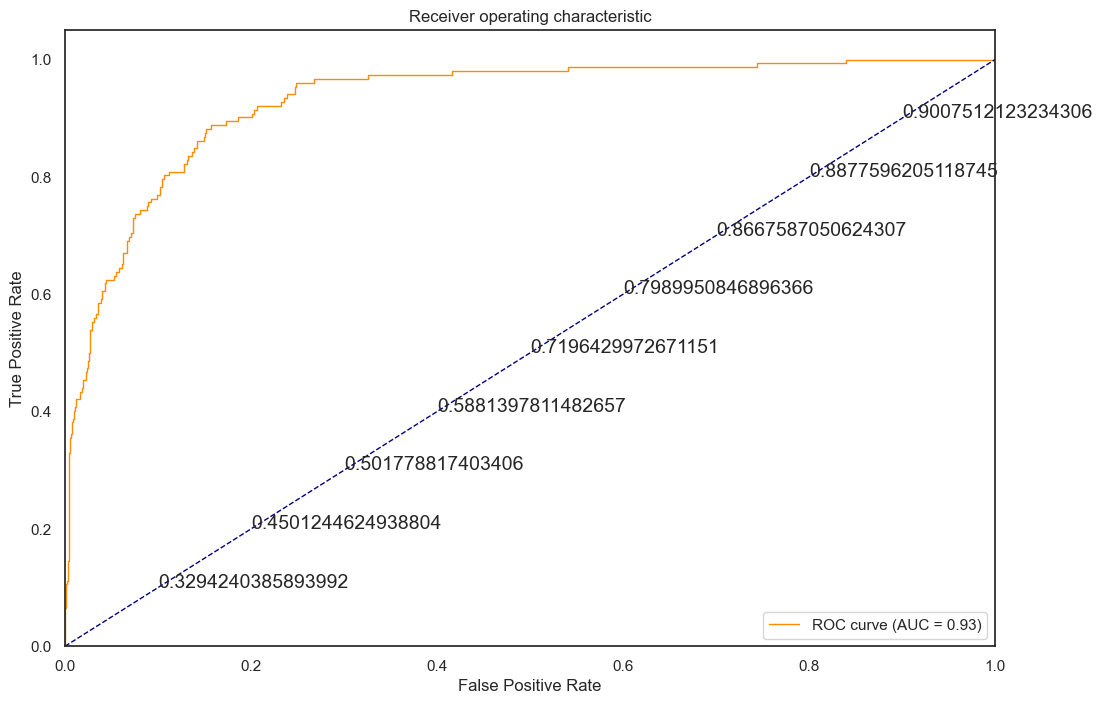

In [138]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, rfc.predict_proba(X_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (AUC = %0.2f)' % roc_auc)

for label in range(1,10,1):
    plt.text((10-label)/10,(10-label)/10,thresholds[label*15],fontdict={'size': 14})
    
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

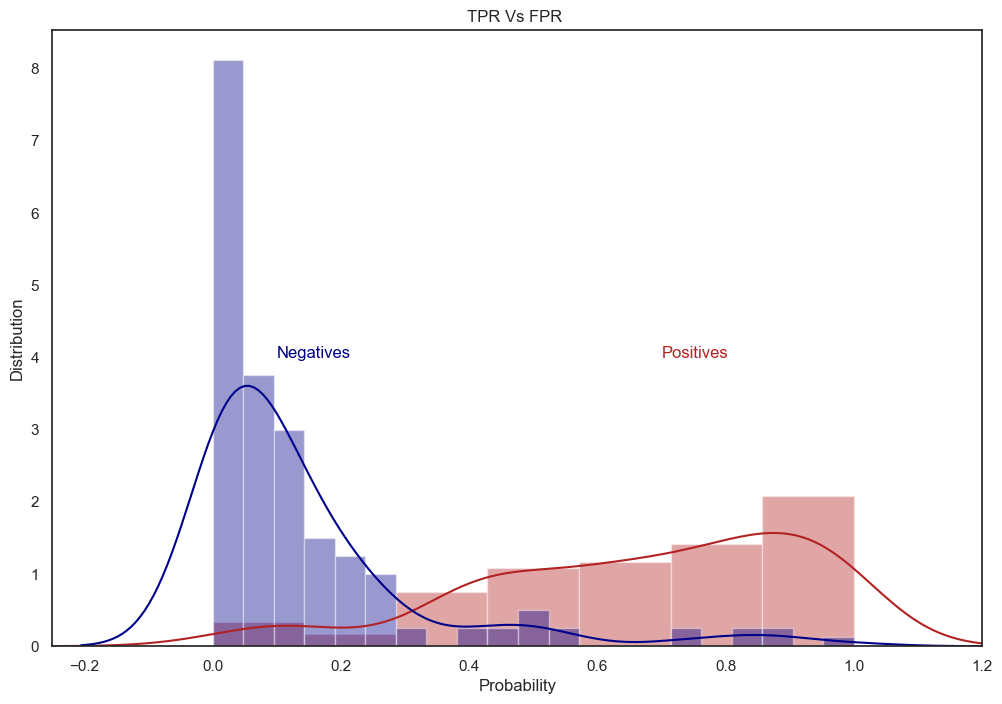

In [139]:
# Random Forest : TPR Vs FPR

fig = plt.figure(figsize=(12,8))

sns.distplot(tpr,color='firebrick')

sns.distplot(fpr,color='darkblue')
plt.title('TPR Vs FPR ')
plt.xlim([-.25, 1.2])

plt.text(0.1,4,'Negatives',color='darkblue')
plt.text(0.7,4,'Positives',color='firebrick')
plt.xlabel('Probability')
plt.ylabel('Distribution')
plt.show()

In [140]:
rfc_train_pred = (rfc.predict_proba(X_train)[:,1]>0.5).astype(bool)   # Set threshold to 0.5
rfc_val_pred = (rfc.predict_proba(X_val)[:,1]>0.5).astype(bool)# Set threshold to 0.5

#### Random Forest : Model Evaluation

In [141]:
# 
from sklearn.metrics import confusion_matrix,accuracy_score,cohen_kappa_score,roc_auc_score,f1_score,roc_curve

cm0 = confusion_matrix(y_train, rfc_train_pred,labels=[1,0])
print('Confusion Matrix Train : \n', cm0)

cm1 = confusion_matrix(y_val, rfc_val_pred,labels=[1,0])
print('Confusion Matrix Test: \n', cm1)

total0=sum(sum(cm0))
total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy0=(cm0[0,0]+cm0[1,1])/total0
print ('Accuracy Train : ', accuracy0)

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Test : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

KappaValue=cohen_kappa_score(y_val, rfc_val_pred)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(y_val, rfc_val_pred)
print("AUC         :",AUC)


print("F1-Score Train",f1_score(y_train,rfc_train_pred))
print("F1-Score Validation : ",f1_score(y_val, rfc_val_pred))

Confusion Matrix Train : 
 [[ 318   36]
 [ 391 3042]]
Confusion Matrix Test: 
 [[ 124   28]
 [ 188 1283]]
Accuracy Train :  0.8872458410351202
Accuracy Test :  0.866913123844732
Sensitivity :  0.8157894736842105
Specificity :  0.8721957851801495
Kappa Value : 0.4674031940494422
AUC         : 0.8439926294321801
F1-Score Train 0.5983066792097836
F1-Score Validation :  0.5344827586206896


### Random Forest FeatureImportance

In [142]:
feature_list = list(Test_category_removed_groupedbyProv_PF.columns)
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list[1:], importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Top -20 features impacting Random forest model and their importance score :- \n',)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:15]];

Top -20 features impacting Random forest model and their importance score :- 

Variable: PerProviderAvg_InscClaimAmtReimbursed Importance: 0.09
Variable: InscClaimAmtReimbursed Importance: 0.07
Variable: PerAttendingPhysicianAvg_InscClaimAmtReimbursed Importance: 0.07
Variable: PerOperatingPhysicianAvg_InscClaimAmtReimbursed Importance: 0.06
Variable: PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed Importance: 0.04
Variable: PerClmAdmitDiagnosisCodeAvg_DeductibleAmtPaid Importance: 0.04
Variable: PerClmDiagnosisCode_1Avg_DeductibleAmtPaid Importance: 0.04
Variable: PerOperatingPhysicianAvg_IPAnnualReimbursementAmt Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_7 Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_8 Importance: 0.03
Variable: ClmCount_Provider_ClmDiagnosisCode_9 Importance: 0.03
Variable: DeductibleAmtPaid    Importance: 0.02
Variable: AdmitForDays         Importance: 0.02
Variable: PerProviderAvg_DeductibleAmtPaid Importance: 0.02
Variable: 

In [143]:
## Lets predict on Test data

rfc_test_pred = rfc.predict(X_teststd)
rfc_test_pred=pd.DataFrame(rfc_test_pred)
rfc_test_pred.head(2)

,0
0,0
1,0


In [144]:
## Lets Replace 1 with Yes and 0 With No

Replacement = {1:'Yes',0:'No'}

Labels=rfc_test_pred[0].apply(lambda x : Replacement[x])
Labels.value_counts()

No     1092
Yes     261
Name: 0, dtype: int64

In [145]:
submission_rfc=pd.DataFrame({"Provider":Test_category_removed_groupedbyProv_PF.Provider})
submission_rfc['PotentialFraud']=Labels
submission_rfc.shape

(1353, 2)

In [146]:
   #write Submission file

submission_rfc.to_csv("Submission_Random_Forest_Estimator_F1_60_estimators_3000.csv",index=False)

#### Other Models and their performances

In [147]:
## Lets import packages 
from collections import Counter
from sklearn.naive_bayes import MultinomialNB

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pprint

In [148]:
clfs = {
    #'mnb': MultinomialNB(),
    'svm1': SVC(C=0.01,kernel='linear',probability=1),
    'svm2': SVC(C=0.01,kernel='rbf',probability=1),
    'svm3': SVC(C=.01,kernel='poly',degree=2,probability=1),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(class_weight='balanced'),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression(class_weight='balanced'),
    'xgb': XGBClassifier(booster='gbtree')
}

In [149]:
## Lets Fit These models and check their performance 

f1_scores = dict()
for clf_name in clfs:
    print(clf_name)
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    y_pred =((clf.predict_proba(X_val)[:,1]>0.5).astype(bool))
    f1_scores[clf_name] = f1_score(y_pred, y_val)

svm1
svm2
svm3
ada
dtc
gbc
lr
xgb
[20:32:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [150]:
pprint.pprint(f1_scores) #Printing F1 Scores


{'ada': 0.515625,
 'dtc': 0.45051194539249145,
 'gbc': 0.5748987854251012,
 'lr': 0.5833333333333334,
 'svm1': 0.5137614678899083,
 'svm2': 0.5551020408163265,
 'svm3': 0.41000000000000003,
 'xgb': 0.5301204819277108}


Above figures shows that Logistic regression model is performing better compared to other models.

Principal Component Analysis

In [152]:
Train_category_removed_groupedbyProv_PF.head(2)
Test_category_removed_groupedbyProv_PF.head(2)

,Provider,InscClaimAmtReimbursed,DeductibleAmtPaid,AdmitForDays,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,...,ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1,ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_OperatingPhysician,ClmCount_Provider_BeneID_ClmProcedureCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1,ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1,Gender_2,Race_2,Race_3,Race_5
0,PRV51002,53790,380.0,0.0,2424,2460,331.0,302.0,338.0,385.0,...,0.0,202.0,30.0,0.0,204.0,0.0,134.0,30.0,2.0,4.0
1,PRV51006,30720,0.0,0.0,1224,1224,169.0,135.0,154.0,189.0,...,0.0,99.0,26.0,0.0,99.0,0.0,59.0,26.0,0.0,0.0


In [153]:
# Apply Standard Scaler to scale data
sc_pca=StandardScaler()
sc_pca=sc.fit(Train_category_removed_groupedbyProv_PF.iloc[:,2:])
Train_category_removed_groupedbyProv_PF_scaled=sc_pca.transform(Train_category_removed_groupedbyProv_PF.iloc[:,2:])
Train_category_removed_groupedbyProv_PF_scaled=pd.DataFrame(Train_category_removed_groupedbyProv_PF_scaled)

Test_category_removed_groupedbyProv_PF_scaled=sc_pca.transform(Test_category_removed_groupedbyProv_PF.iloc[:,1:])
Test_category_removed_groupedbyProv_PF_scaled=pd.DataFrame(Test_category_removed_groupedbyProv_PF_scaled)

In [154]:
Train_category_removed_groupedbyProv_PF_scaled.shape

(5410, 156)

#### PCA : Use maximum Variance

In [155]:
from sklearn.decomposition import PCA  #import PCA
# Lets Take 29 PCA components
pca = PCA(n_components=29)
pca.fit(Train_category_removed_groupedbyProv_PF_scaled.iloc[:,0:])
# PCA(copy=True, iterated_power='auto', n_components=29, random_state=None,
#   svd_solver='auto', tol=0.0, whiten=False)
print('PCA Explained Variance :\n',np.round(pca.explained_variance_ratio_,3))

PCA Explained Variance :
 [0.684 0.219 0.024 0.015 0.009 0.007 0.005 0.004 0.004 0.003 0.003 0.002
 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.    0.    0.    0.    0.   ]


In [156]:
## Transform test and train based on train components
train_pca=pca.transform(Train_category_removed_groupedbyProv_PF_scaled.iloc[:,0:])

test_pca=pca.transform(Test_category_removed_groupedbyProv_PF_scaled)

In [157]:
print('Train Shape:',train_pca.shape)
print('Test Shape:',test_pca.shape)
# Train Shape: (5410, 29)
# Test Shape: (1353, 29)
## Convert to Pandas dataframe

train_pca=pd.DataFrame((train_pca))
test_pca=pd.DataFrame(test_pca)

Train Shape: (5410, 29)
Test Shape: (1353, 29)


In [158]:
print('Train Shape:',train_pca.shape)
print('Test Shape:',test_pca.shape)

Train Shape: (5410, 29)
Test Shape: (1353, 29)


In [159]:
#Add target to train Data
train_pca['PotentialFraud']=Train_category_removed_groupedbyProv_PF.PotentialFraud
train_pca.isnull().sum().sum()
print('Train PCA',train_pca.shape)
#train_pca.head()
print('Test PCA',test_pca.shape)

Train PCA (5410, 30)
Test PCA (1353, 29)


In [160]:
train_pca.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,PotentialFraud
0,-2.421928,-0.361085,0.179567,0.584970,0.200628,0.097415,-0.289875,-0.067863,-0.036668,0.128826,...,-0.076651,-0.023398,-0.040351,-0.048373,0.156389,0.116811,-0.160529,-0.172383,0.474504,0
1,9.205174,-9.735367,-0.613849,4.473384,-4.186291,-0.019620,0.278324,-0.380602,0.382162,0.247965,...,0.217026,-0.267960,-0.002812,-0.483727,-0.432574,0.425864,-0.315689,0.377697,-0.538719,1


#### Auto - Encoder

**An Autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. Recently, the autoencoder concept has become more widely used for learning generative models of data.

We will use the same technique to learn patterns in non fraud data and we will train the model accordingly.We will use reconstruction error threshold ,to predict the Target class of data.

In [161]:
from sklearn.model_selection import train_test_split
#Convertin data to array
train_pca = np.array(train_pca)
test_pca = np.array(test_pca)

In [162]:
X_train_pca,X_test_pca = train_test_split(train_pca,test_size=0.2,random_state=123)

print(X_train_pca.shape)
print(X_test_pca.shape)
print(test_pca.shape)

(4328, 30)
(1082, 30)
(1353, 29)


In [164]:
#obtaining the fraud and non-fraud records in train
print(np.unique(X_train_pca[:,29],return_counts=True))
print(np.unique(X_test_pca[:,29],return_counts=True))

(array([0., 1.]), array([3916,  412], dtype=int64))
(array([0., 1.]), array([988,  94], dtype=int64))


In [165]:
#No consider only the non-fraud recors for training
X_train_NF = X_train_pca[X_train_pca[:,-1]==0]
X_train_NF = X_train_NF[:,:-1]
print(X_train_NF.shape)

(3916, 29)


In [166]:
#eparating out the fraud records from the train
X_train_F = X_train_pca[X_train_pca[:,-1]==1]
print(X_train_F.shape)

(412, 30)


In [167]:
#Adding/concatenating the fraud records from train data to test
X_test_pca = np.concatenate((X_test_pca,X_train_F),axis=0)
print(X_test_pca.shape)

(1494, 30)


In [168]:
X_test,X_eval = train_test_split(X_test_pca,test_size=0.2,random_state=123)

In [169]:
print(X_test.shape)
print(X_eval.shape)

(1195, 30)
(299, 30)


In [171]:
#Separatin the independent and the class variable
y_test = X_test[:,-1]
X_test = X_test[:,:-1]

In [172]:
#Expandin the dimensions of y for later concatenation
y_test = np.expand_dims(y_test,axis=1)
y_test.shape

(1195, 1)

### Autoencoder Network Building

In [173]:
input_dim = X_train_NF.shape[1]
encoding_dim =15

In [175]:
from tensorflow.keras.models import Sequential 
from keras.layers import Dense,Dropout

autoencoder = Sequential()
autoencoder.add(Dropout(0.2,input_shape=(input_dim,)))
autoencoder.add(Dense(encoding_dim,activation='relu'))
autoencoder.add(Dense(input_dim, activation='linear'))    #Add Dense layer of size of input shape

In [176]:
nb_epoch = 100    #number of epochs
batch_size = 32   #batchsize or sample size

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mse'])                      ## We will use mse as a metric as each neuron can be a linear regression model

In [177]:
## Fit the model and save history
hist = []
for _ in range(100):
    hist.append(autoencoder.fit(X_train_NF, X_train_NF,
                    epochs=1,
                    batch_size=batch_size,
                    shuffle=True,
                     validation_split=0.3,
                    verbose=0).history)

In [178]:
hist[0:5]   #First 5 records of history

[{'loss': [1.4694353342056274],
  'mse': [1.4694353342056274],
  'val_loss': [0.9366151690483093],
  'val_mse': [0.9366151690483093]},
 {'loss': [0.9852378964424133],
  'mse': [0.9852378964424133],
  'val_loss': [0.6377310752868652],
  'val_mse': [0.6377310752868652]},
 {'loss': [0.636442244052887],
  'mse': [0.636442244052887],
  'val_loss': [0.40524813532829285],
  'val_mse': [0.40524813532829285]},
 {'loss': [0.4343460202217102],
  'mse': [0.4343460202217102],
  'val_loss': [0.26788249611854553],
  'val_mse': [0.26788249611854553]},
 {'loss': [0.3557301461696625],
  'mse': [0.3557301461696625],
  'val_loss': [0.21525099873542786],
  'val_mse': [0.21525099873542786]}]

In [179]:
## Making predictions on the train data
predictions=autoencoder.predict(X_train_NF)

123/123 [==============================] - 0s 2ms/step


In [180]:
predictions[0:2]   #See the predictions

array([[-3.9106953e+00,  5.1485401e-01,  4.6816793e-01,  4.9460858e-02,
         1.5936193e-01, -3.9867312e-03,  2.1484452e-01,  2.3063907e-02,
         8.6758584e-03, -5.3007007e-03, -1.3155669e-02, -6.7579150e-03,
         2.9886633e-02, -7.1453005e-03,  4.9985498e-02,  8.9251399e-03,
        -4.2109564e-02,  1.2590677e-02, -1.2505054e-03, -1.3970256e-02,
        -2.2332456e-02,  3.0839428e-02,  1.8843859e-02,  1.0197580e-02,
         5.4280311e-03,  1.8208593e-02, -1.3644140e-02,  1.1467934e-02,
         4.2916834e-03],
       [-2.5278447e+00, -1.3052640e+00,  9.1993999e-01, -1.5676216e+00,
         5.5928051e-01, -5.0090939e-01, -2.0402357e-01,  2.0200675e-02,
        -7.0741880e-01,  3.7745953e-02,  1.0151470e-01,  7.3050976e-02,
         1.3758469e-01, -2.5387514e-01, -2.9171556e-02,  2.6085389e-01,
        -1.2032986e-03, -6.4881682e-02, -1.2515962e-02,  2.3548275e-02,
         4.9153723e-02,  4.6527773e-02,  1.2855123e-01,  2.5455654e-03,
        -3.6891133e-02, -4.9642324e-03,

In [181]:
##We want to separate out fraud records and non-fraud records for later use
f = np.hstack((X_test,y_test))
print(f.shape)

test_nf=f[f[:,29]==0]
print('Test_nf',test_nf.shape)

test_f=f[f[:,29]==1]
print('Test_f',test_f.shape)

(1195, 30)
Test_nf (788, 30)
Test_f (407, 30)


In [182]:
#Getting the errors from the non fraud data separately 
autoencoder.evaluate(test_nf[:,:29],test_nf[:,:29])

25/25 [==============================] - 0s 2ms/step - loss: 0.0868 - mse: 0.0868


[0.08675139397382736, 0.08675139397382736]

In [183]:
#Getting the errors from the fraud data separately
autoencoder.evaluate(test_f[:,:29],test_f[:,:29])

13/13 [==============================] - 0s 2ms/step - loss: 10.9284 - mse: 10.9284


[10.928360939025879, 10.928360939025879]

In [184]:
#Obtaining predictions for non fraud records
predictions_nf=autoencoder.predict(test_nf[:,:29])
    #Obtaining predictions for fraud records
predictions_f=autoencoder.predict(test_f[:,:29])
#Identifying the error computation method by autoencoder(Mean Squared Error). The computation is as follows 
np.mean(np.square(np.abs(test_nf[:,:29]-predictions_nf)))

13/13 [==============================] - 0s 2ms/step


0.08675140583629332

In [185]:
#Computing errors on the non-fraud data
errors_nf = np.mean(np.square(np.abs(test_nf[:,:29]-predictions_nf)), axis=1)
errors_nf[0:5]

array([0.00142518, 0.0015326 , 0.0234917 , 0.00251607, 0.00197932])

In [186]:
#Computing errors on the fraud data
errors_f = np.mean(np.square(np.abs(test_f[:,:29]-predictions_f)), axis=1)
errors_f[0:5]

array([ 0.15083081,  0.10428863,  0.30443015,  6.91086023, 13.90306193])

In [187]:
#Computing the distribution of errors in both non-fraud and fraud data
print(np.min(errors_nf))
print(np.max(errors_nf))
print(np.median(errors_nf))

print(np.min(errors_f))
print(np.max(errors_f))
print(np.median(errors_f))

0.0005897535276911974
27.761885105492276
0.0061152192127530754
0.0019489375324263454
892.2666577127513
0.36774061784450557


Text(0.5, 0.98, 'Error boxplot for Fraud and nonfraud')

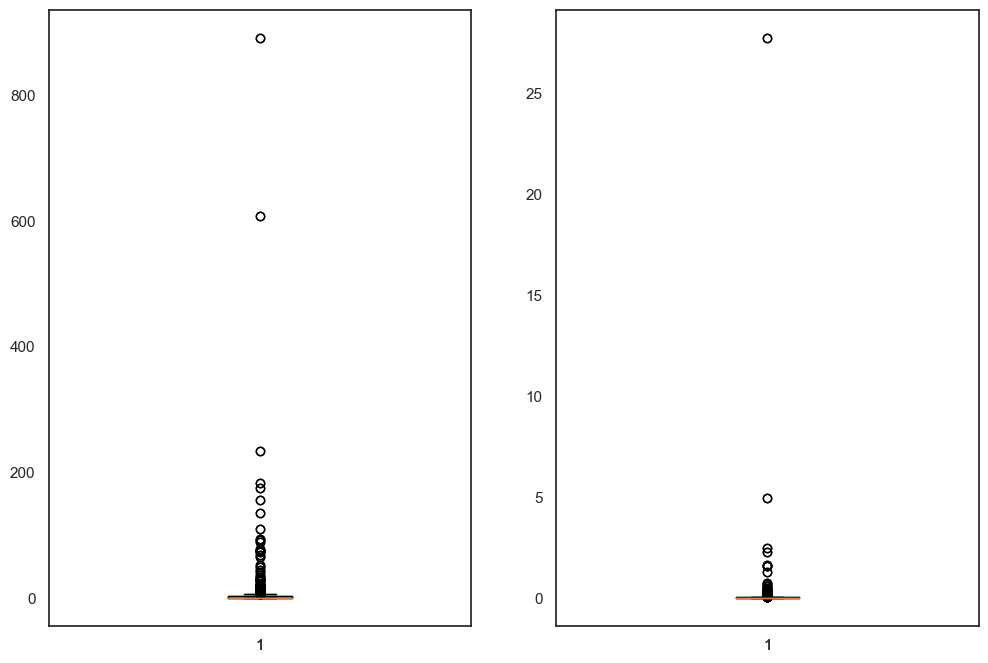

In [191]:
#0.24613738200955018
#PLotting the error box plots 

plt.subplot(1, 2,1)
plt.boxplot(errors_f)

plt.subplot(1, 2, 2)
plt.boxplot(errors_nf)

fig.suptitle('Error boxplot for Fraud and nonfraud')#0.24613738200955018
#PLotting the error box plots 

plt.subplot(1, 2,1)
plt.boxplot(errors_f)

plt.subplot(1, 2, 2)
plt.boxplot(errors_nf)

fig.suptitle('Error boxplot for Fraud and nonfraud')

In [192]:
#Experimentation to fix a threshold for classification of a transaction into fraud or non-fraud
print(sum(errors_nf>np.median(errors_f)))
print(sum(errors_f<np.median(errors_f)))
print(sum(errors_f<np.median(errors_nf)))
print(sum(errors_nf>np.median(errors_nf)))

18
203
6
394


In [193]:
print(errors_nf.shape)
print(errors_f.shape)

(788,)
(407,)


In [194]:
print(predictions_nf.shape)
print(predictions_f.shape)

(788, 29)
(407, 29)


In [195]:
test_pred = autoencoder.predict(X_test[:,:29])
test_recon  = (((test_pred-X_test)**2).mean(-1))

train_pred = autoencoder.predict(X_train_NF[:,:29])
mean_recon = (((train_pred - X_train_NF)**2).mean(-1).mean())

from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix

scores_f1 = []
thres = []

th = 0
for i in range(100):
    th+=0.1
    fraud = (test_recon>mean_recon+th)
    scores_f1.append(f1_score(y_test,fraud))
    thres.append(th+mean_recon)
    

123/123 [==============================] - 0s 2ms/step


In [196]:
X_test.shape

(1195, 29)

0.17462641605908663


array([[745,  43],
       [153, 254]], dtype=int64)

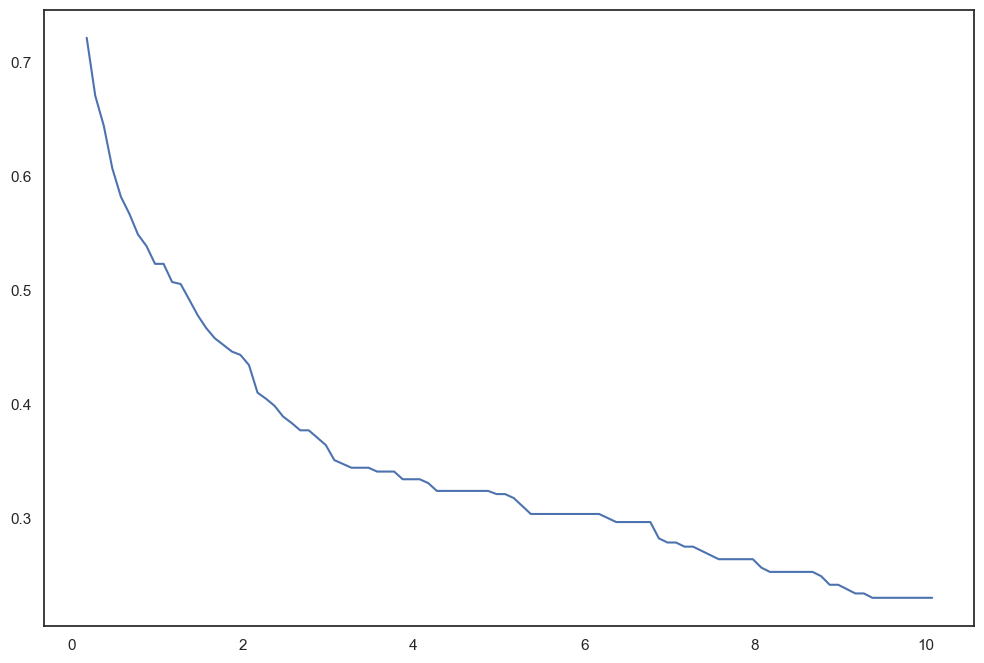

In [197]:
plt.plot(thres, scores_f1)

print(thres[np.array(scores_f1).argmax()])

fraud = (test_recon>thres[np.array(scores_f1).argmax()])

confusion_matrix(y_test, fraud)

In [198]:
##Predicting on Valdation 

predictions_eval=autoencoder.predict(X_eval[:,:29])
errors_eval=np.square(np.subtract(predictions_eval,X_eval[:,:29]))
threshold=0.1718219230420997

fraud_eval=(((errors_eval-X_eval[:,:29])**2).mean(-1))>threshold
print(confusion_matrix(y_true=X_eval[:,29],y_pred=fraud_eval,labels=[1,0]))

10/10 [==============================] - 0s 2ms/step
[[ 99   0]
 [192   8]]


In [199]:
#Obtaining errors on individual attributes on non-fraud data
ind_errors_nf=np.abs(np.subtract(predictions_nf,test_nf[:,:29]))
print(ind_errors_nf.shape)
# (788, 29)
#Obtaining errors on individual attributes on fraud data
ind_errors_f=np.abs(np.subtract(predictions_f,test_f[:,:29]))
print(ind_errors_f.shape)
# (407, 29)
#Combining all fraud and non-fraud data errors
X=np.concatenate((ind_errors_f,ind_errors_nf),axis=0)
print(X.shape)

(788, 29)
(407, 29)
(1195, 29)


In [200]:
#Creating a target column
x=np.array([1,0])
Y=np.repeat(x,[788,407])
#Expanding the shape of the target for merging with all other attributes
print(Y.shape)
Y = np.expand_dims(Y, axis=1)
print(Y.shape)

(1195,)
(1195, 1)


In [201]:
#Concatenating all the attribute errors with target class
X=np.concatenate((X,Y),axis=1)
print(X.shape)

(1195, 30)


In [202]:
map(str,range(X.shape[1]))

In [203]:
#Creating a data frame and naming the columns
X=pd.DataFrame(X)
X.columns = map(str, range(X.shape[1]))
#Melting the data for box plot visualization
M = pd.melt(X, "29", var_name="var", value_name="value")
M['29'].astype('category')
M.tail()
#M.head()

,29,var,value
34650,0.0,28,0.034922
34651,0.0,28,0.289266
34652,0.0,28,0.001689
34653,0.0,28,0.054476
34654,0.0,28,0.006612


AttributeError: module 'seaborn' has no attribute 'factorplot'

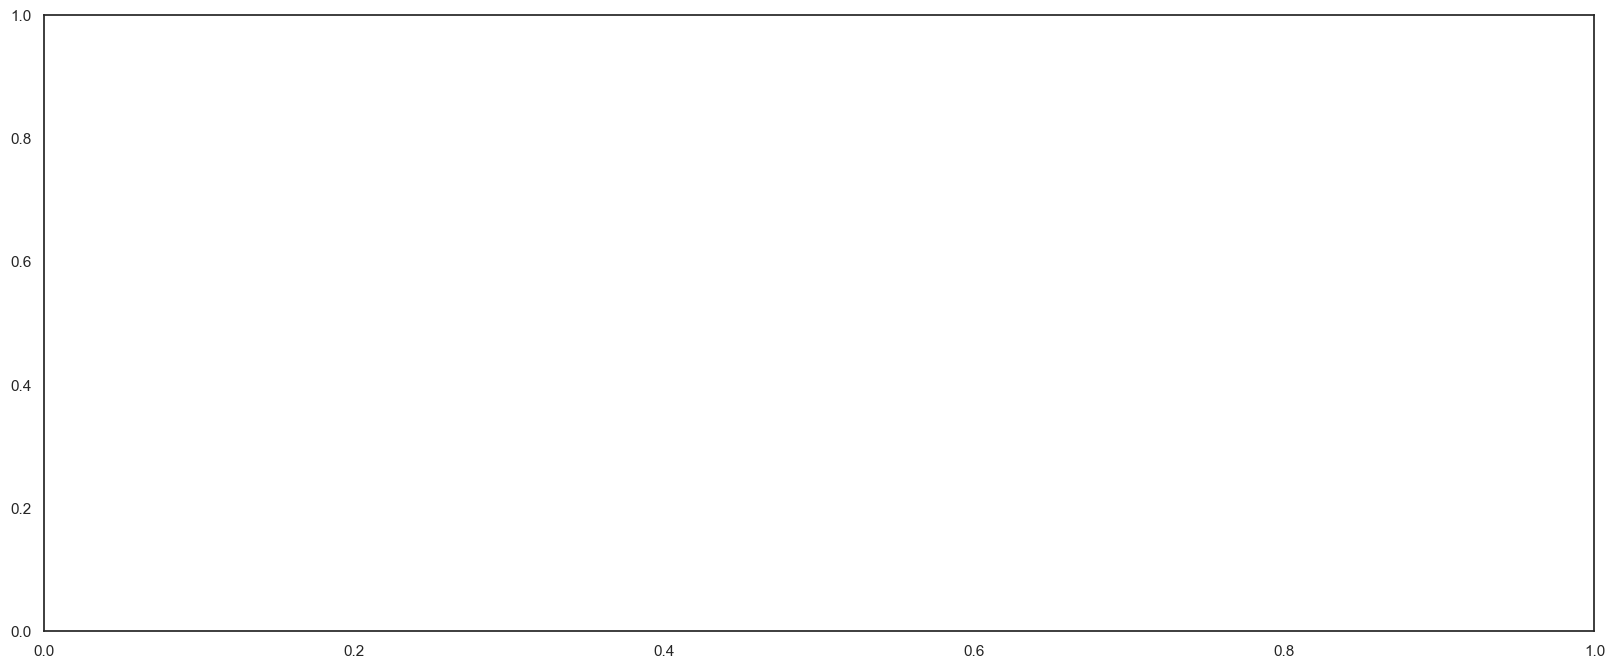

In [206]:
import seaborn as sns
size=(20,8)
fig,ax = plt.subplots(figsize=size)
# the size of A4 paper
g=sns.factorplot(x="var", y='value', hue="29", data=M, kind='box',ax=ax)
ax.set_yscale(value="linear")
ax.set_ybound(0,3)
ax.legend(fontsize=20)

In [207]:
pred_nf=ind_errors_nf[:,[0,1,11,17,18,4,8,14]]
np.mean(pred_nf,axis=0)

array([0.35432293, 0.16676749, 0.10203942, 0.13667516, 0.11111926,
       0.09843297, 0.05442778, 0.10413832])

In [208]:
pred_f=ind_errors_f[:,[0,1,11,17,18,4,8,14]]
np.mean(pred_f,axis=0)

array([6.03732144, 3.40127884, 0.67850507, 0.6378807 , 0.65941417,
       0.801915  , 0.50668431, 0.53549948])

In [209]:
#Percentile distribution of absolute errors
percentile_nf=np.percentile(ind_errors_nf[:,[0,1,11,17,18,4,8,14]],[10,20,30,40,50,60,70,80,90,100],axis=0)
percentile_nf

array([[3.29395984e-02, 2.27161922e-02, 6.45223396e-03, 1.41118315e-02,
        9.42089051e-03, 1.06506325e-02, 1.18765849e-03, 1.16073856e-02],
       [7.12065285e-02, 4.29791979e-02, 9.88087126e-03, 2.30772997e-02,
        1.57252031e-02, 2.05754111e-02, 2.24986709e-03, 2.13828260e-02],
       [1.11267573e-01, 5.72291773e-02, 1.67919744e-02, 3.84119771e-02,
        2.41133571e-02, 2.84580206e-02, 4.41867292e-03, 3.11690778e-02],
       [1.55328870e-01, 7.86763603e-02, 2.26314490e-02, 5.04234304e-02,
        3.61264328e-02, 3.30217447e-02, 8.45628739e-03, 3.81770426e-02],
       [1.93947511e-01, 9.76999387e-02, 3.23656532e-02, 7.40939080e-02,
        5.25789478e-02, 3.87959366e-02, 1.38657870e-02, 5.47741583e-02],
       [2.23154258e-01, 1.12253003e-01, 4.85138379e-02, 9.86542126e-02,
        7.87885238e-02, 5.17666388e-02, 2.38630532e-02, 7.25722962e-02],
       [2.59894581e-01, 1.38054261e-01, 7.54560764e-02, 1.32288941e-01,
        1.12551587e-01, 7.99597573e-02, 4.20697671e-02, 1.

In [210]:
percentile_nf[:,7]

array([0.01160739, 0.02138283, 0.03116908, 0.03817704, 0.05477416,
       0.0725723 , 0.10308112, 0.14445578, 0.22588993, 2.21853032])

In [211]:
percentile_f=np.percentile(ind_errors_f[:,[0,1,11,17,18,4,8,14]],[10,20,30,],axis=0)
np.percentile(ind_errors_f[:,[0,1,11,17,18,4,8,14]],[10,20,30,40,50,60,70,80,90,100],axis=0)

array([[2.38720050e-01, 7.48806195e-02, 5.83547076e-02, 4.95442633e-02,
        4.05771944e-02, 4.03941142e-02, 2.45859635e-02, 3.12938186e-02],
       [5.05337438e-01, 1.55807296e-01, 1.11796211e-01, 1.03053795e-01,
        9.60579171e-02, 1.01289874e-01, 4.46474777e-02, 7.88039734e-02],
       [8.17552815e-01, 2.74295290e-01, 1.75393646e-01, 1.65917513e-01,
        1.50658598e-01, 1.76010863e-01, 6.44110926e-02, 1.24698758e-01],
       [1.25152041e+00, 4.76644140e-01, 2.33263175e-01, 2.34227059e-01,
        2.37673548e-01, 2.52992478e-01, 9.56568107e-02, 1.94081847e-01],
       [1.82047252e+00, 8.81696975e-01, 3.19835308e-01, 3.23738000e-01,
        3.44900464e-01, 3.35226768e-01, 1.31863815e-01, 2.37421916e-01],
       [2.90131452e+00, 1.27979375e+00, 4.50688661e-01, 4.51141649e-01,
        4.79455223e-01, 4.67343156e-01, 1.99650372e-01, 3.18724600e-01],
       [4.98885386e+00, 2.20866172e+00, 6.28629063e-01, 6.06088312e-01,
        6.80219085e-01, 7.44668362e-01, 2.79738562e-01, 4.

In [212]:
percentile_f[:,7]

array([0.03129382, 0.07880397, 0.12469876])

In [213]:
# Set Threshold

thr= 0.10003411   #0.50795386       #0.32079228

test_pred = autoencoder.predict(X_test)
test_pred.shape

38/38 [==============================] - 0s 2ms/step


(1195, 29)

In [214]:
recon_error= np.abs(np.subtract(test_pred,X_test[:,:29]))
recon_error.shape

(1195, 29)

In [215]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix
fraud = (recon_error[:,1]>thr)
print("Recall=",recall_score(y_test,fraud))
print("Precision=",precision_score(y_test,fraud))
print("Accuracy=",accuracy_score(y_test,fraud))
print("F1-Score",f1_score(y_test,fraud))

Recall= 0.8574938574938575
Precision= 0.4774281805745554
Accuracy= 0.6317991631799164
F1-Score 0.6133567662565904


In [216]:
print(confusion_matrix(y_true=y_test,y_pred=fraud,labels=[1,0]))

[[349  58]
 [382 406]]


In [217]:
# Evaluaton

predictions_eval=autoencoder.predict(X_eval[:,:29])
predictions_eval.shape
# (299, 29)
ind_errors_eval=np.abs(np.subtract(predictions_eval,X_eval[:,:29]))
ind_errors_eval.shape

10/10 [==============================] - 0s 2ms/step


(299, 29)

In [218]:
fraud_eval=ind_errors_eval[:,1]>thr
print("Recall",recall_score(X_eval[:,29],fraud_eval))
print("Precision",precision_score(X_eval[:,29],fraud_eval))
print("Accuracy",accuracy_score(X_eval[:,29],fraud_eval))
print("F1-Score",f1_score(X_eval[:,29],fraud_eval))

Recall 0.898989898989899
Precision 0.478494623655914
Accuracy 0.6421404682274248
F1-Score 0.624561403508772


In [219]:
print(confusion_matrix(y_true=X_eval[:,29],y_pred=fraud_eval,labels=[1,0]))

[[ 89  10]
 [ 97 103]]


In [220]:
fraud_eval[:6]

array([ True, False,  True,  True,  True, False])

## Let's predict on unseen data

In [221]:
predictions_unseen=autoencoder.predict(test_pca[:,:29])
predictions_unseen.shape
# (1353, 29)
ind_errors_unseen=np.abs(np.subtract(predictions_unseen,test_pca[:,:29]))
ind_errors_unseen.shape
# (1353, 29)
fraud_unseen=ind_errors_unseen[:,1]>thr
fraud_unseen.shape

43/43 [==============================] - 0s 2ms/step


(1353,)

In [222]:
fraud_unseen[:5]

array([ True,  True,  True,  True,  True])

#### Evaluate results with the best performing model

In [223]:
print("Recall",recall_score((log.predict_proba(X_teststd)[:,1]>0.60).astype(bool),fraud_unseen))
print("Precision",precision_score((log.predict_proba(X_teststd)[:,1]>0.60).astype(bool),fraud_unseen))
print("Accuracy",accuracy_score((log.predict_proba(X_teststd)[:,1]>0.60).astype(bool),fraud_unseen))
print("F1-Score",f1_score((log.predict_proba(X_teststd)[:,1]>0.60).astype(bool),fraud_unseen))

Recall 0.9964664310954063
Precision 0.533585619678335
Accuracy 0.6341463414634146
F1-Score 0.6950092421441776


In [224]:
fraud_unseen=pd.DataFrame(fraud_unseen)
fraud_unseen.shape
fraud_unseen.head(2)

,0
0,True
1,True


In [225]:
Replacement = {1:'Yes',0:'No'}

AE_Labels=fraud_unseen[0].apply(lambda x : Replacement[x])
AE_Labels.value_counts()

Yes    1057
No      296
Name: 0, dtype: int64

In [226]:
submission_AutoEncoder=pd.DataFrame({"Provider":Test_category_removed_groupedbyProv_PF.Provider})
submission_AutoEncoder['PotentialFraud']=AE_Labels
submission_AutoEncoder.head(16)

,Provider,PotentialFraud
0,PRV51002,Yes
1,PRV51006,Yes
2,PRV51009,Yes
3,PRV51010,Yes
4,PRV51018,Yes
5,PRV51019,No
6,PRV51020,Yes
7,PRV51022,Yes
8,PRV51028,Yes
9,PRV51033,Yes


In [228]:
submission_AutoEncoder.shape
# (1353, 2)
# Autoencoder with 2 hidden layers

df = pd.DataFrame(train_pca)  #Again use train 
df.shape

(5410, 30)

In [229]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-2.421928,-0.361085,0.179567,0.584970,0.200628,0.097415,-0.289875,-0.067863,-0.036668,0.128826,...,-0.076651,-0.023398,-0.040351,-0.048373,0.156389,0.116811,-0.160529,-0.172383,0.474504,0.0
1,9.205174,-9.735367,-0.613849,4.473384,-4.186291,-0.019620,0.278324,-0.380602,0.382162,0.247965,...,0.217026,-0.267960,-0.002812,-0.483727,-0.432574,0.425864,-0.315689,0.377697,-0.538719,1.0
2,-0.033340,2.030714,-0.708517,-0.144327,0.014684,-0.050896,0.093603,0.277685,0.059218,0.082225,...,-0.022656,-0.253874,0.035628,-0.100636,0.087974,-0.096555,-0.095986,0.072303,0.050992,0.0
3,28.122060,15.761146,-6.434526,-2.065467,-0.987402,-0.632177,-0.170787,2.794478,0.768994,2.430367,...,-1.296592,0.044789,1.027461,-0.676831,-0.343160,-0.442076,-0.255366,0.040582,-0.166274,1.0
4,-2.193429,0.734671,-0.049191,0.097636,-0.092838,-0.049003,0.437435,0.023028,-0.007755,0.116718,...,0.033356,-0.071963,-0.096730,0.058365,0.090679,-0.065297,0.101808,-0.073405,0.044841,0.0


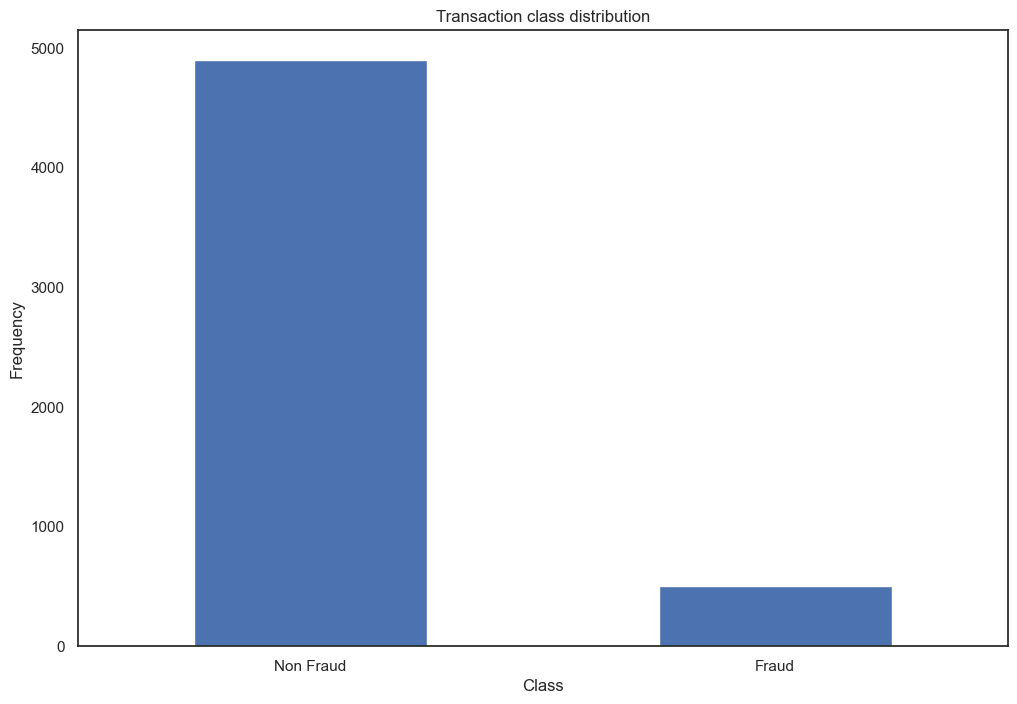

In [230]:
df.isnull().values.any()   #check null values
# False
# Lets check distruibution of classes
count_classes = pd.value_counts(df.iloc[:,29], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [231]:
frauds = df[df.iloc[:,29] == 1]
normal = df[df.iloc[:,29] == 0]
print('Fraud data shape:',frauds.shape)
# Fraud data shape: (506, 30)
print('Normal data shape:',normal.shape)

Fraud data shape: (506, 30)
Normal data shape: (4904, 30)


In [232]:
X_train_AE, X_test_AE = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train_AE = X_train_AE[X_train_AE.iloc[:,29] == 0]
X_train_AE = X_train_AE.drop([29], axis=1)
y_test_AE = X_test_AE[29]
X_test_AE = X_test_AE.drop([29], axis=1)
X_train_AE = X_train_AE.values
X_test_AE = X_test_AE.values
X_train_AE.shape

###df[ df.columns[[1,3]] ]

(3927, 29)

In [233]:
# Add 2 hidden layers to autoencoder
## AutoEncoder with 2 Hidden Layers

input_dim = X_train_AE.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)## AutoEncoder with 2 Hidden Layers


In [234]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',     #Tensorboard 
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train_AE, X_train_AE,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_AE, X_test_AE),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
123/123 [==============================] - 4s 23ms/step - loss: 1.0522 - accuracy: 0.2534 - val_loss: 3.5591 - val_accuracy: 0.5795
Epoch 2/100
123/123 [==============================] - 1s 6ms/step - loss: 0.9773 - accuracy: 0.7171 - val_loss: 3.4153 - val_accuracy: 0.7597
Epoch 3/100
123/123 [==============================] - 1s 7ms/step - loss: 0.9176 - accuracy: 0.6641 - val_loss: 3.2989 - val_accuracy: 0.7440
Epoch 4/100
123/123 [==============================] - 1s 6ms/step - loss: 0.8750 - accuracy: 0.7204 - val_loss: 3.2113 - val_accuracy: 0.8355
Epoch 5/100
123/123 [==============================] - 1s 5ms/step - loss: 0.8425 - accuracy: 0.8144 - val_loss: 3.1370 - val_accuracy: 0.8567
Epoch 6/100
123/123 [==============================] - 1s 6ms/step - loss: 0.8163 - accuracy: 0.8645 - val_loss: 3.0743 - val_accuracy: 0.8835
Epoch 7/100
123/123 [==============================] - 1s 6ms/step - loss: 0.7947 - accuracy: 0.8852 - val_loss: 3.0151 - val_accuracy: 0.887

Epoch 58/100
123/123 [==============================] - 1s 5ms/step - loss: 0.5589 - accuracy: 0.8999 - val_loss: 2.0810 - val_accuracy: 0.9030
Epoch 59/100
123/123 [==============================] - 1s 6ms/step - loss: 0.5581 - accuracy: 0.8961 - val_loss: 2.0528 - val_accuracy: 0.8965
Epoch 60/100
123/123 [==============================] - 1s 6ms/step - loss: 0.5575 - accuracy: 0.8948 - val_loss: 2.0356 - val_accuracy: 0.9002
Epoch 61/100
123/123 [==============================] - 1s 5ms/step - loss: 0.5569 - accuracy: 0.8908 - val_loss: 2.0375 - val_accuracy: 0.9057
Epoch 62/100
123/123 [==============================] - 1s 5ms/step - loss: 0.5561 - accuracy: 0.8936 - val_loss: 2.0219 - val_accuracy: 0.8983
Epoch 63/100
123/123 [==============================] - 1s 5ms/step - loss: 0.5555 - accuracy: 0.8948 - val_loss: 2.0244 - val_accuracy: 0.8965
Epoch 64/100
123/123 [==============================] - 1s 5ms/step - loss: 0.5549 - accuracy: 0.8966 - val_loss: 2.0319 - val_accuracy:

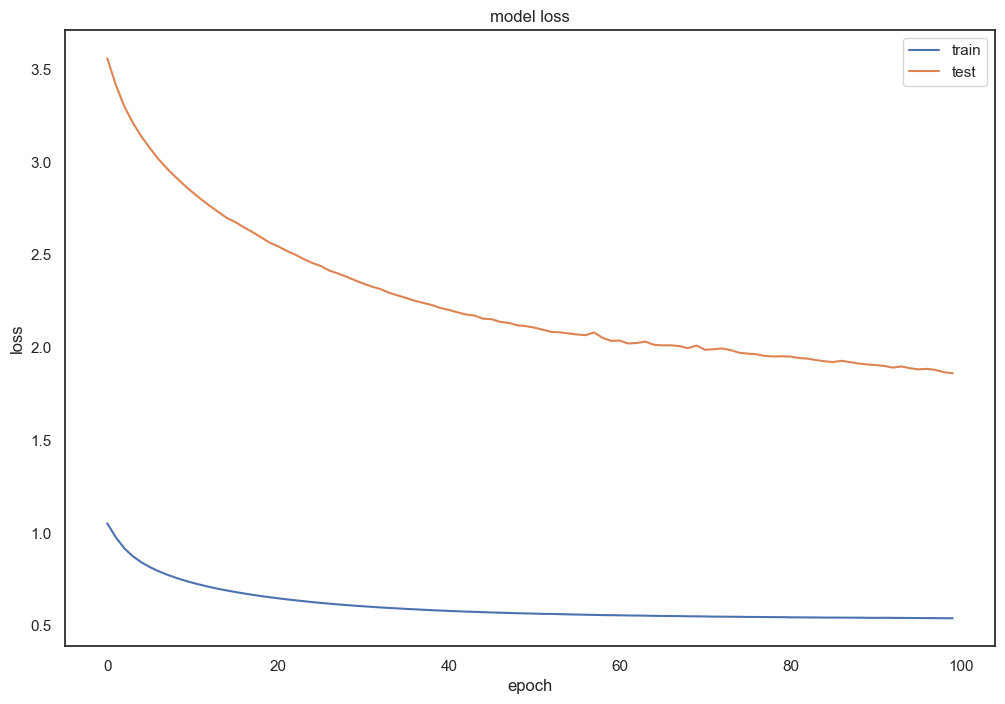

In [235]:
#Lets Load Model
autoencoder = load_model('model.h5')
#plot the loss and Val loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [236]:
## Lets predict on test and evaluate

predictions = autoencoder.predict(X_test_AE)
mse = np.mean(np.power(X_test_AE - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test_AE})
error_df.describe()

34/34 [==============================] - 0s 2ms/step


,reconstruction_error,true_class
count,1082.000000,1082.000000
mean,1.860587,0.097043
std,13.240526,0.296153
min,0.029144,0.000000
25%,0.264273,0.000000
50%,0.450507,0.000000
75%,0.583902,0.000000
max,302.290821,1.000000


(0.0, 30.0)

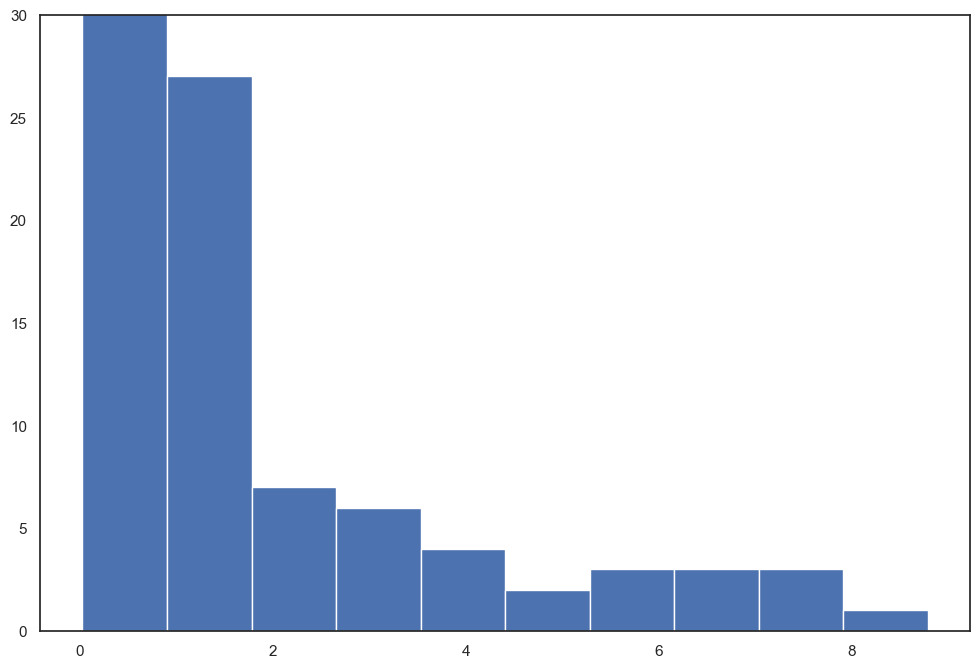

In [237]:
#Reconstruction error for Normal data
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

ax.set_ylim(0,30)

(0.0, 30.0)

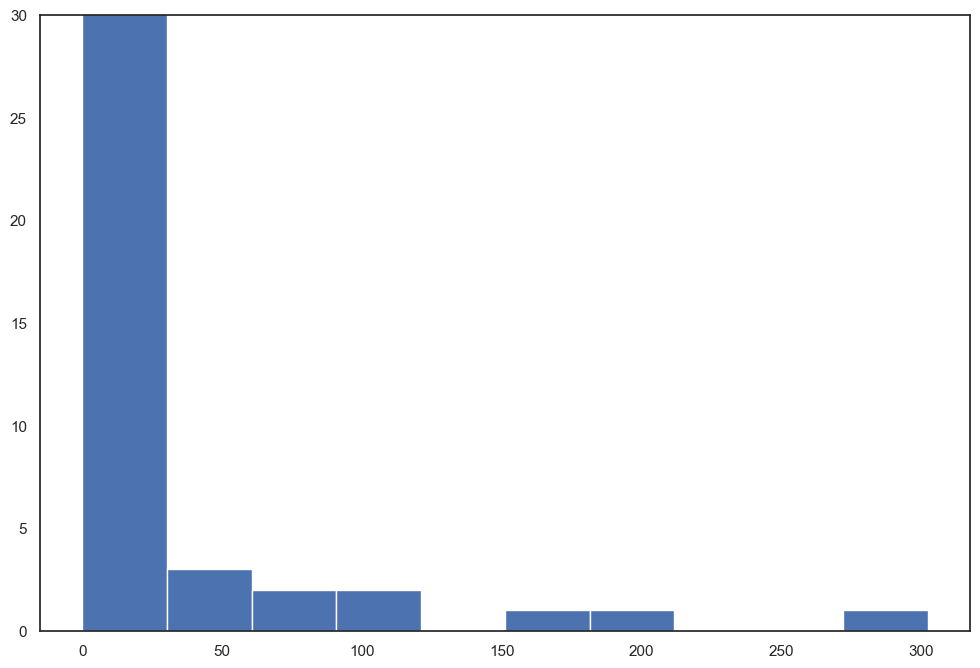

In [238]:
## Reconstruction Error with Fraud data

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
ax.set_ylim(0,30)

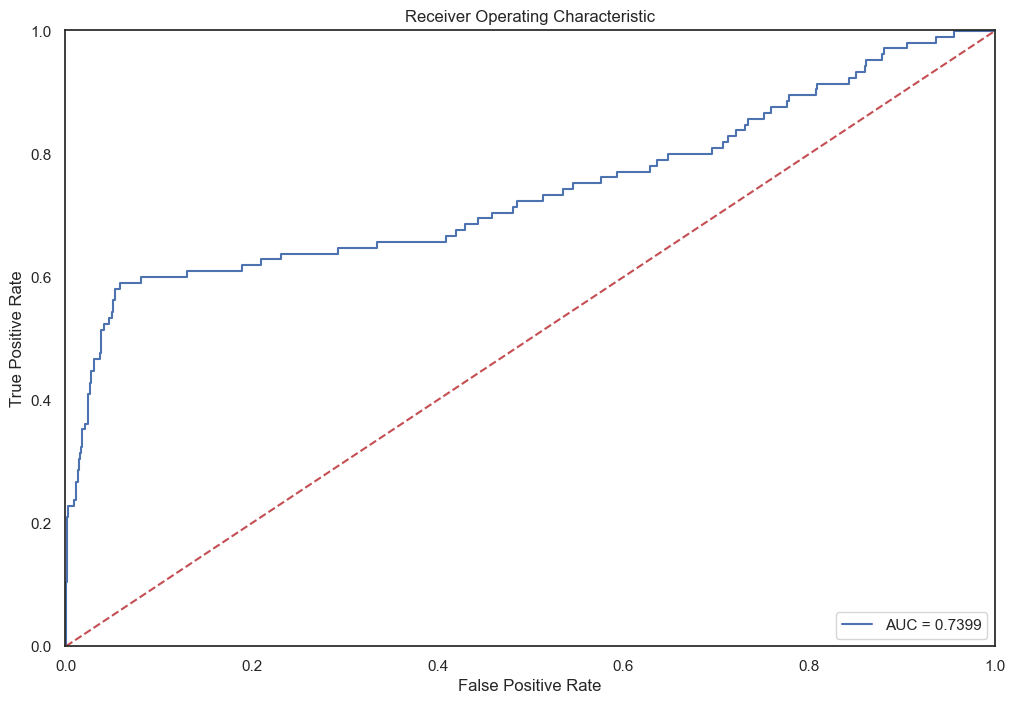

In [239]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
###ROC for errors and true class

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

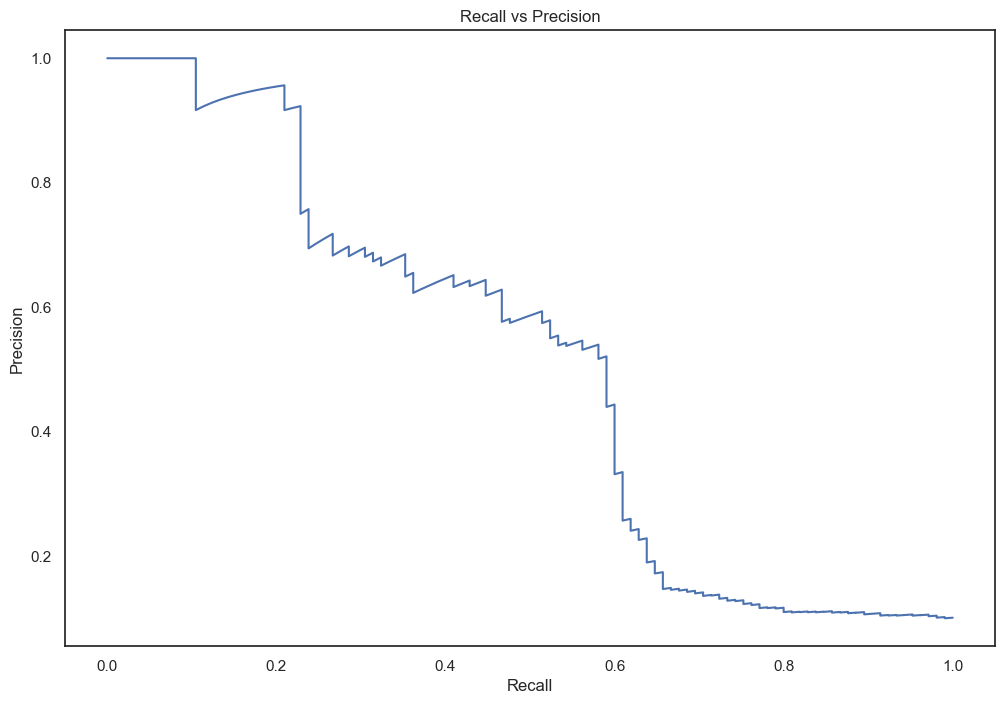

In [240]:
## Recall Vs Precision

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

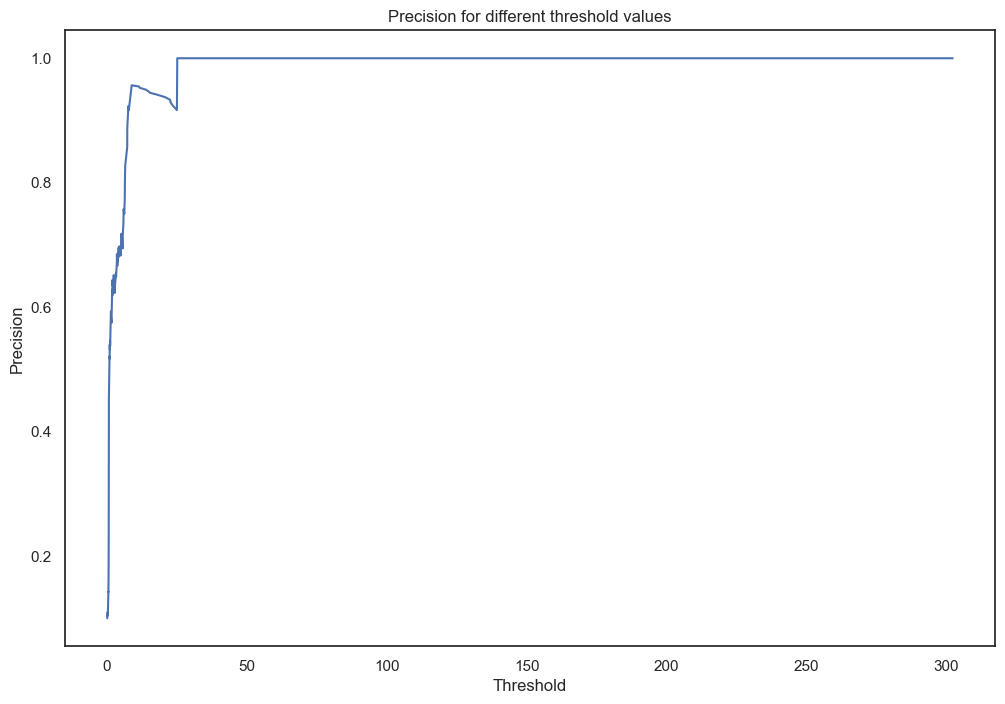

In [241]:
#Threshold Vs Precision 
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

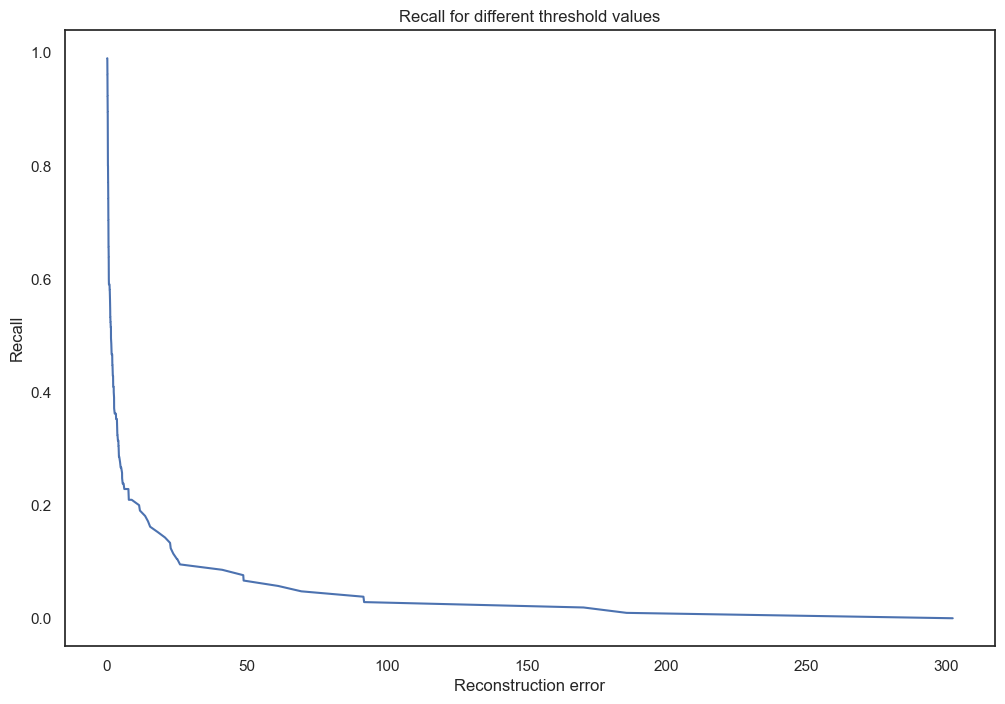

In [242]:
##Recall vs Thresold
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [243]:
threshold =0.95

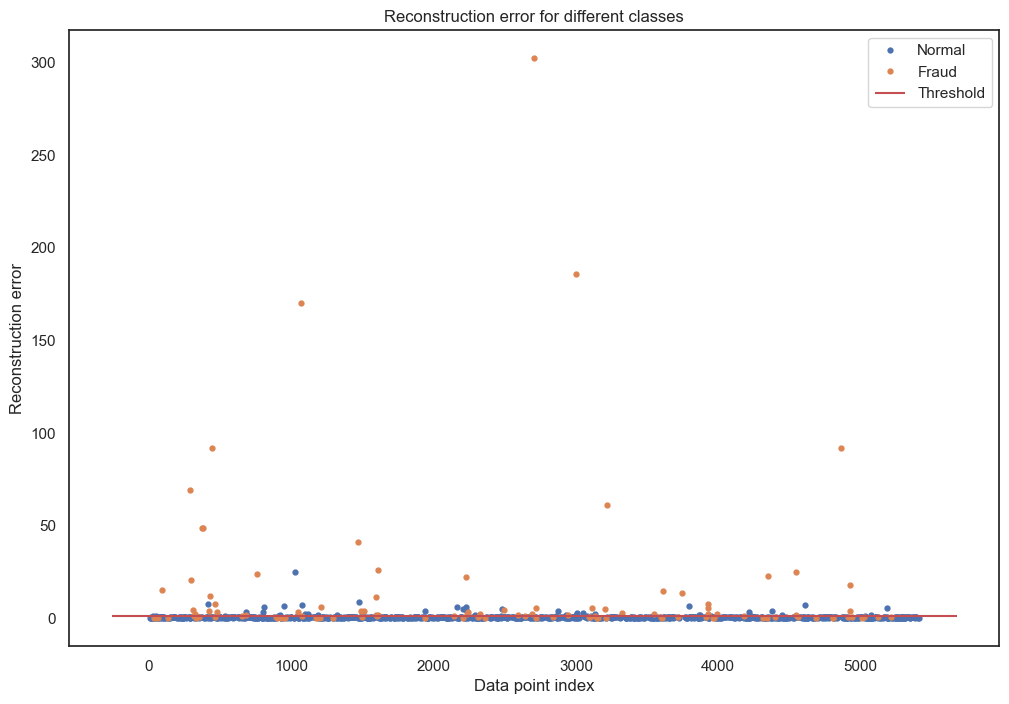

In [244]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

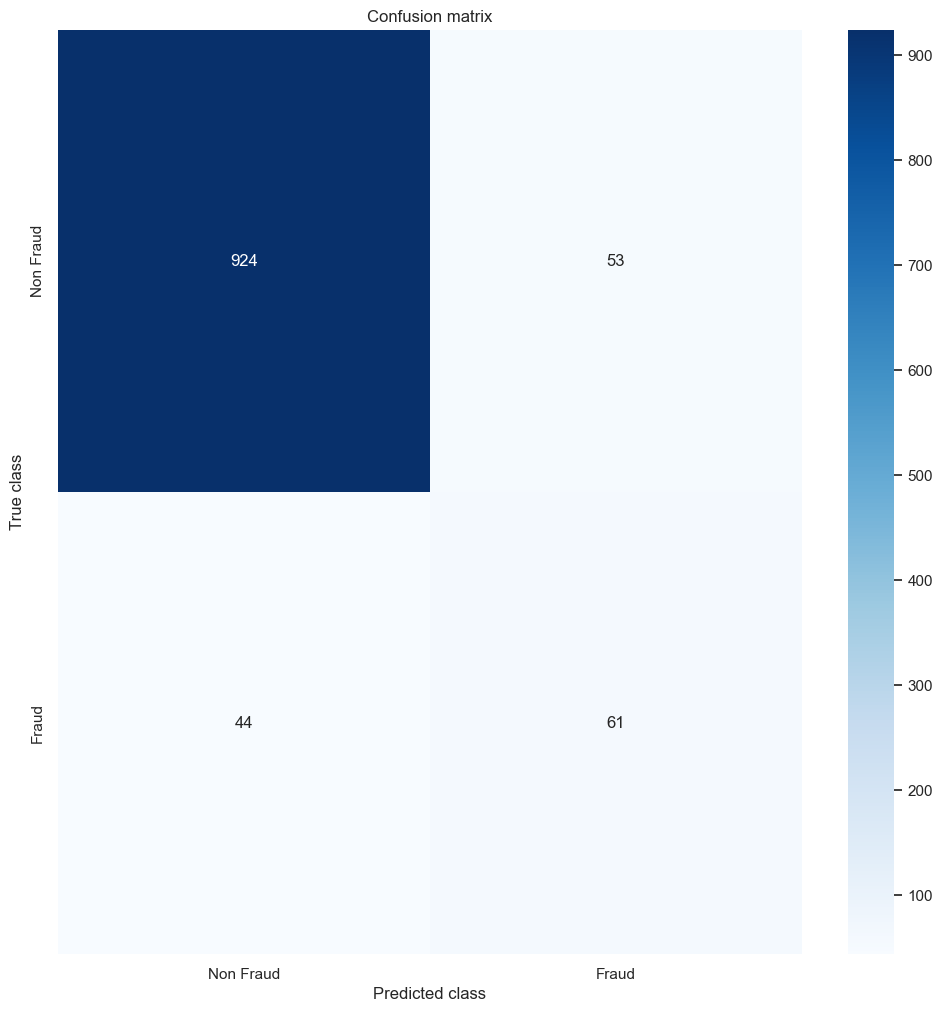

In [245]:
## Predict class based on error threshold

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred,labels=[0,1])
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap='Blues');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [246]:
#print('F1_Score:',f1_score(error_df.true_class, y_pred))
print('F1_Score:',f1_score(error_df.true_class, y_pred))

F1_Score: 0.5570776255707763


In [247]:
cm1 = confusion_matrix(error_df.true_class, y_pred,labels=[1,0])
print('Confusion Matrix Val: \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy

accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy Val: ', accuracy1)


sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity Val: ', sensitivity1 )


specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity Val: ', specificity1)

KappaValue=cohen_kappa_score(error_df.true_class, y_pred)
print("Kappa Value :",KappaValue)
AUC=roc_auc_score(error_df.true_class, y_pred)

print("AUC         :",AUC)

print("F1-Score Val  : ",f1_score(error_df.true_class, y_pred))


Confusion Matrix Val: 
 [[ 61  44]
 [ 53 924]]
Accuracy Val:  0.910351201478743
Sensitivity Val:  0.580952380952381
Specificity Val:  0.9457523029682702
Kappa Value : 0.5072998525946164
AUC         : 0.7633523419603256
F1-Score Val  :  0.5570776255707763


### With just 2 layers and 100 epochs we achieved F1 score 0.57.

Our model seems to catch a lot of the fraudulent cases. The number of normal transactions classified as frauds is really high. Based on business decision ,one can set threshold to create a tradeoff between Fraud and Non Fraud class predictions. Adding More data time to time and training will improve the performance of detection of new fraud patterns and help us to understand Providers fradulent behaviour.

### Summary of Project

**In this Project,I have used Supervised and Unsupervised machine learning algorithms to classify Fradulent behaviour of Healthcare providers.For the purpose of classifying providers in Fraud and Non Fraud category I used following methods:-

1) Feature Engineering

Medicare fraud is categorised as organized crime which involves peers working together to create fraud transactions of claims.Adding features from grouping them helped in improving accuracy of prediction and fraud pattern recognition. Grouping and aggregating numeric features to provider level helped in detecting behaviour of their transactions overall.

2) Logistic Regression Classifier

Features derived from above step are trained using logistic regression and evaluated.My decision of choosing LR is to check linear behaviour between dependent and independent variables.Also Logistic model adds explicability to the predictions. Performance of the LR model showcase the linearity between variables.

3) Random Forest Classifier

One of benefits of Random forest which excites most is, the power of handle large data set with higher dimensionality. It can handle thousands of input variables and identify most significant variables. Further, the model outputs Importance of variable, which can be a very handy feature.It also checks for non linearity between variables.

4) Autoencoders

Autoencoders are neural networks that aims to copy their inputs to their outputs. They work by compressing the input into a latent-space representation, and then reconstructing the output from this representation. My aim for the project is to train non fraud data using autoeencoder and reconstructing it back.While reconstructing Faud data it will create an error,called as reconstruction error.Based on the threshold setting of reconstruction errors, we can easily predict Fraudulent behaviour of healthcare provider.

Conclusion Important Features In this Project ,I studied behaviour of Providers and found following important features impactful in predicting Fraud/NonFraud are folowing:

1) PerProviderAvg_InscClaimAmtReimbursed( Importance: 8%)

2) InscClaimAmtReimbursed (Importance: 7%)

3) PerAttendingPhysicianAvg_InscClaimAmtReimbursed (Importance: 7%)

4) PerOperatingPhysicianAvg_InscClaimAmtReimbursed (Importance: 6%)

5) PerClmAdmitDiagnosisCodeAvg_InscClaimAmtReimbursed (Importance: 4%)

Model Performance Based on business requirement,Threshold can be set on prediction probabilities.This threshold can be varied for different performance of these models.Recall and Precision tradeoff is entirely based on business decision.

Our models consistentently performed with ~0.90 Accuracy, ~0.80 AUROC score and ~0.55 Kappa Score.

**

Model Improvement **Based on the above model performance ,there is a scope in improving model performance by :

1) Adding more fraud data to the training dataset help in predicting unseen fraudulent behaviour time to time.

2) Ensembling methods with parameter tuning can improve performance of the models.

3) Vectorizing Medical codes(ICD 9 codes) with Count Vectoriser may add performance imporvement.**

Business Recommendation and Improvement

**1) Above model will help in predicting Provider fraud ,which will be helpful for insurance companies to scrutinize claims thoroughly.

2) Further improvement in the project will help Government to take decision against fradulent health providers and will help in ammending rules and regulations in this domain.

3) Improvement in the model will help in detecting networks of fraud Physicians,Providers and Beneficiaries.

4) This type of project will help in improving health of economy by reducing inflation caused by fraud peers and lowering down insurance premiums which will certainly not cause health to become costly affair.

The End**